# Loading Libraries

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, \
ConfusionMatrixDisplay, RocCurveDisplay, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.decomposition import PCA

C:\Users\Ray\anaconda3\envs\dojo-env\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
data = pd.read_csv('DataSets\Metabolic  Syndrome.csv')
df = data.copy()
df.head()

,seqn,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
0,62161,22,Male,Single,8200.0,White,81.0,23.3,0,3.88,4.9,92,41,84,No MetSyn
1,62164,44,Female,Married,4500.0,White,80.1,23.2,0,8.55,4.5,82,28,56,No MetSyn
2,62169,21,Male,Single,800.0,Asian,69.6,20.1,0,5.07,5.4,107,43,78,No MetSyn
3,62172,43,Female,Single,2000.0,Black,120.4,33.3,0,5.22,5.0,104,73,141,No MetSyn
4,62177,51,Male,Married,NaN,Asian,81.1,20.1,0,8.13,5.0,95,43,126,No MetSyn


In [3]:
df['MetabolicSyndrome'].value_counts(normalize=True)

No MetSyn    0.657643
MetSyn       0.342357
Name: MetabolicSyndrome, dtype: float64

# Explanation of Data
* This dataset is sourced from [data.world](https://data.world/informatics-edu/metabolic-syndrome-prediction), and was gathered from the [NHANES](https://www.cdc.gov/nchs/nhanes/index.htm) initiative
* The dataset has a variety of features for a patient that could possibly be used to predict Metabolic Syndrome.
* The target is Metabolic Syndrome, with our positive class (1) being MetSyn and our negative class (0) being No Metsyn
* Each row represents a person in our dataset
* This is a classification problem
* The dataset has 13 Features
* The dataset has 2401 Records
* There seems to be some missing data for Marital, Income, WaistCirc, and BMI. I will have to evaluate that. The data is also imbalanced, I will have to deal with that when trying different models

# Data Cleaning

## Duplicates

In [4]:
df.duplicated().sum()

0

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2401 entries, 0 to 2400
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   seqn               2401 non-null   int64  
 1   Age                2401 non-null   int64  
 2   Sex                2401 non-null   object 
 3   Marital            2193 non-null   object 
 4   Income             2284 non-null   float64
 5   Race               2401 non-null   object 
 6   WaistCirc          2316 non-null   float64
 7   BMI                2375 non-null   float64
 8   Albuminuria        2401 non-null   int64  
 9   UrAlbCr            2401 non-null   float64
 10  UricAcid           2401 non-null   float64
 11  BloodGlucose       2401 non-null   int64  
 12  HDL                2401 non-null   int64  
 13  Triglycerides      2401 non-null   int64  
 14  MetabolicSyndrome  2401 non-null   object 
dtypes: float64(5), int64(6), object(4)
memory usage: 281.5+ KB


## Dropping Columns
The data has 15 columns and 2401 entries. The Target is Metabolic Syndrome. From first glance, I want to remove 'seqn', and convert 'MetabolicSyndrome' to 1 and 0

In [6]:
df['MetabolicSyndrome'].value_counts()

No MetSyn    1579
MetSyn        822
Name: MetabolicSyndrome, dtype: int64

In [7]:
df.drop(columns = ['seqn'], inplace=True)
df['MetabolicSyndrome'].replace({'No MetSyn':0,'MetSyn':1}, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2401 entries, 0 to 2400
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                2401 non-null   int64  
 1   Sex                2401 non-null   object 
 2   Marital            2193 non-null   object 
 3   Income             2284 non-null   float64
 4   Race               2401 non-null   object 
 5   WaistCirc          2316 non-null   float64
 6   BMI                2375 non-null   float64
 7   Albuminuria        2401 non-null   int64  
 8   UrAlbCr            2401 non-null   float64
 9   UricAcid           2401 non-null   float64
 10  BloodGlucose       2401 non-null   int64  
 11  HDL                2401 non-null   int64  
 12  Triglycerides      2401 non-null   int64  
 13  MetabolicSyndrome  2401 non-null   int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 262.7+ KB


## Empty Values

In [8]:
df.isna().sum()

Age                    0
Sex                    0
Marital              208
Income               117
Race                   0
WaistCirc             85
BMI                   26
Albuminuria            0
UrAlbCr                0
UricAcid               0
BloodGlucose           0
HDL                    0
Triglycerides          0
MetabolicSyndrome      0
dtype: int64

We have some empty values for Marital, Income, WaistCirc, and BMI. Lets take a look at each

In [9]:
df.Marital.value_counts(normalize = True)

Married      0.543548
Single       0.227086
Divorced     0.110351
Widowed      0.075695
Separated    0.043320
Name: Marital, dtype: float64

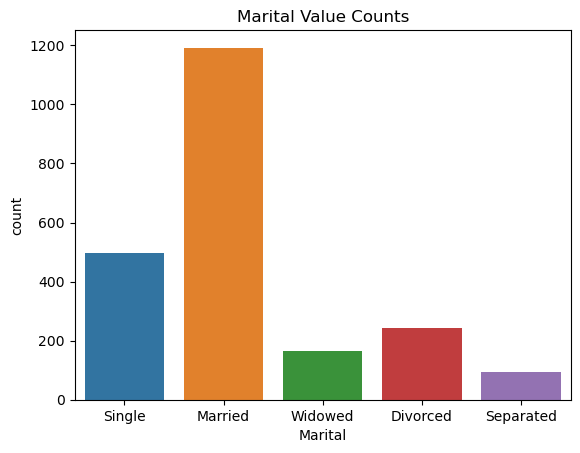

In [10]:
sns.countplot(data = df, x = 'Marital').set(title = 'Marital Value Counts');

The most frequent datapoint is 'Married'. We can fill the nulls with unknown, since this is not ordinal data. 

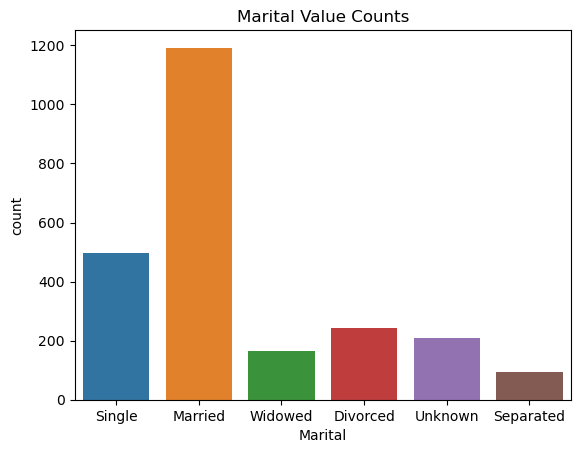

In [11]:
df['Marital'].fillna('Unknown', inplace = True)
sns.countplot(data = df, x = 'Marital').set(title = 'Marital Value Counts');

Marital is handled, lets take a look at Income

In [12]:
df['Income'].describe()

count    2284.000000
mean     4005.253940
std      2954.032186
min       300.000000
25%      1600.000000
50%      2500.000000
75%      6200.000000
max      9000.000000
Name: Income, dtype: float64

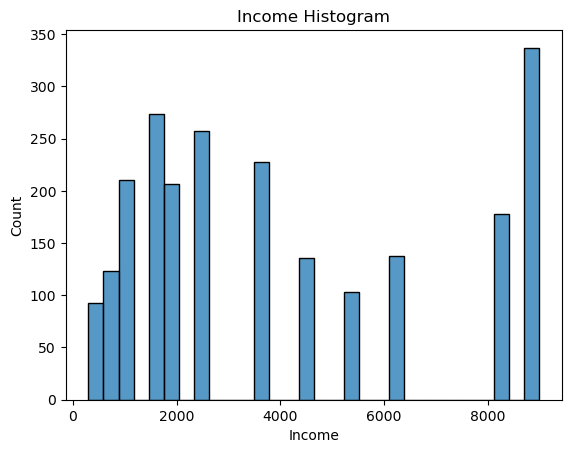

In [13]:
sns.histplot(data = df, x = 'Income', bins = 30).set(title = 'Income Histogram');

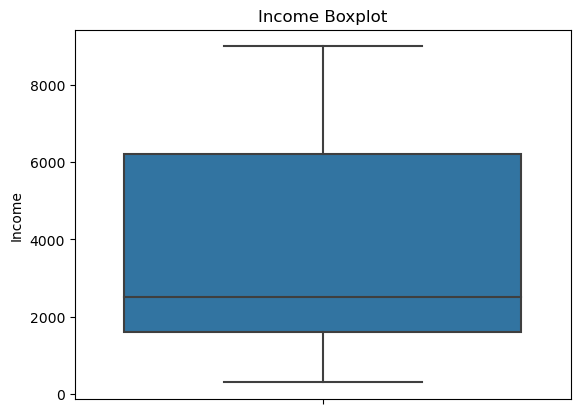

In [14]:
sns.boxplot(data = df, y = 'Income').set(title = 'Income Boxplot');

Income is pretty spread out. The mean for income is much higher than the median as well. There is a big disparity between the min and max, but both have a substantial amount of volume. I think I can fill this with the mean, since 4005 is a close middle point between the min and max.

In [15]:
df['Income'].fillna(df['Income'].mean(), inplace = True)
df['Income'].describe()

count    2401.000000
mean     4005.253940
std      2881.128031
min       300.000000
25%      1600.000000
50%      3500.000000
75%      6200.000000
max      9000.000000
Name: Income, dtype: float64

Up next is WaistCirc

count    2316.000000
mean       98.307254
std        16.252634
min        56.200000
25%        86.675000
50%        97.000000
75%       107.625000
max       176.000000
Name: WaistCirc, dtype: float64

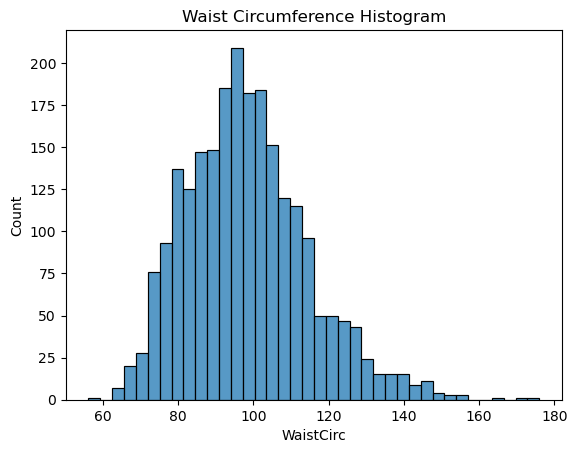

In [16]:
display(df['WaistCirc'].describe())
sns.histplot(data = df, x = 'WaistCirc').set(title = 'Waist Circumference Histogram');

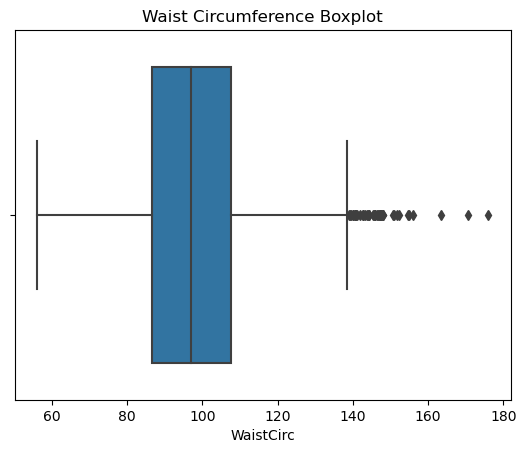

In [17]:
sns.boxplot(data = df, x = 'WaistCirc').set(title = 'Waist Circumference Boxplot');

WaistCirc has some outliers at the higher end. These values could cause me issues when scaling the data, so I want to standardize them down and then fill the nulls with the mean. 

For now, I will just fill the nulls with the mean.

In [18]:
df['WaistCirc'].fillna(df['WaistCirc'].mean(), inplace = True)

count    2401.000000
mean       98.307254
std        15.962233
min        56.200000
25%        87.000000
50%        97.500000
75%       107.200000
max       176.000000
Name: WaistCirc, dtype: float64

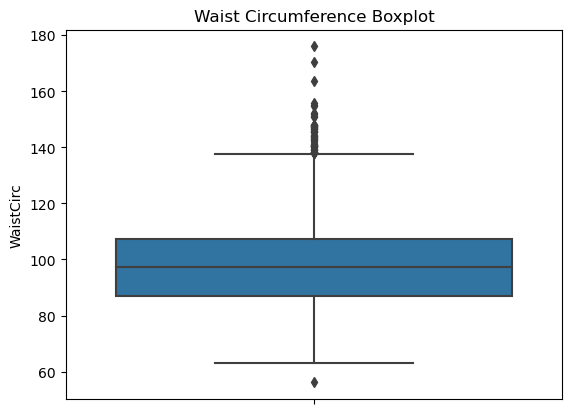

In [19]:
display(df['WaistCirc'].describe())
sns.boxplot(data = df, y= 'WaistCirc').set(title = 'Waist Circumference Boxplot');

BMI is the last one, lets take a look

count    2375.000000
mean       28.702189
std         6.662242
min        13.400000
25%        24.000000
50%        27.700000
75%        32.100000
max        68.700000
Name: BMI, dtype: float64

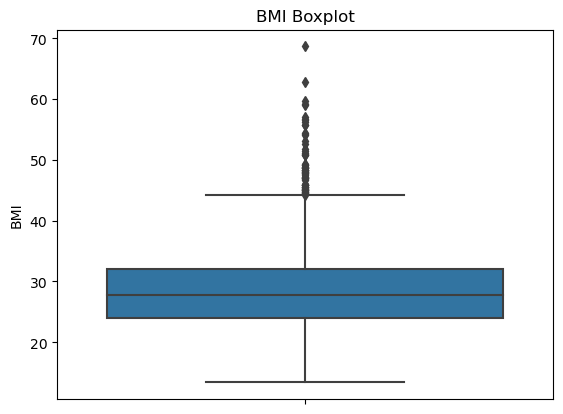

In [20]:
display(df['BMI'].describe())
sns.boxplot(data = df, y= 'BMI').set(title = 'BMI Boxplot');

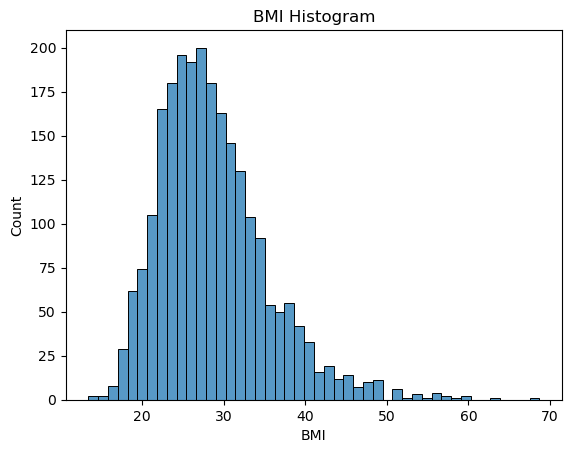

In [21]:
sns.histplot(data = df, x = 'BMI').set(title = 'BMI Histogram');

Similar story here for BMI and WaistCirc. I'm sure there is some correlation between these two metrics, but we will dig into that later. For now, lets replace the nulls with the mean. We will deal with outliers at a later step to keep the steps consistent

count    2401.000000
mean       28.702189
std         6.626057
min        13.400000
25%        24.000000
50%        27.800000
75%        32.000000
max        68.700000
Name: BMI, dtype: float64

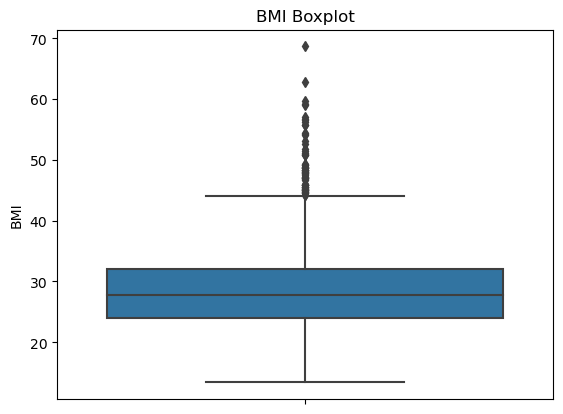

In [22]:
df['BMI'].fillna(df['BMI'].mean(), inplace = True)
display(df['BMI'].describe())
sns.boxplot(data = df, y= 'BMI').set(title = 'BMI Boxplot');

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2401 entries, 0 to 2400
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                2401 non-null   int64  
 1   Sex                2401 non-null   object 
 2   Marital            2401 non-null   object 
 3   Income             2401 non-null   float64
 4   Race               2401 non-null   object 
 5   WaistCirc          2401 non-null   float64
 6   BMI                2401 non-null   float64
 7   Albuminuria        2401 non-null   int64  
 8   UrAlbCr            2401 non-null   float64
 9   UricAcid           2401 non-null   float64
 10  BloodGlucose       2401 non-null   int64  
 11  HDL                2401 non-null   int64  
 12  Triglycerides      2401 non-null   int64  
 13  MetabolicSyndrome  2401 non-null   int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 262.7+ KB


## Outliers and Inconsistencies
Empty values have been fixed. Lets take a look at the numerical columns for inconsistencies and outliers. First, lets create some functions. I want to make:
* A function to plot and describe Numerical Data
* A function to plot and describe Categorical Data
* A function to replace Outliers

### Numerical

In [24]:
# Creating a function for Numerical data analysis
def numdata(data, columns):
    """This function prints out a Statistical description of the column in a dataframe
    and plots a histogram and boxplot of the data"""
    # .describe()
    print(f'Statistical Description: \n {data[columns].describe()} \n')
    
    # Box and Hist plots
    figmain, axmain = plt.subplots(ncols = 2, figsize =(16,4))

    sns.histplot(data = data, x = columns, ax = axmain[0])
    axmain[0].set_title(f'Histogram distribution for {columns}', fontsize = 12)
    
    sns.boxplot(data = data, x = columns, ax = axmain[1])
    axmain[1].set_title(f'Boxplot Distribution for {columns}', fontsize = 12)
    
    figmain.suptitle(f'Hist & Boxplot for {columns}', fontsize = 18)
    figmain.tight_layout()  
    
# Creating a function for Categorical data analysis    
def catdata(data, columns):
    """This function prints the value counts and a Statistical description of the column
    in a dataframe, and plots a countplot of the data."""
    # .value_counts() and .describe()
    print(f'Count of Values: \n{data[columns].value_counts()} \n')
    print(f'Statistical Description: \n {data[columns].describe()}')
    
    # Countplot
    labelorder = data.value_counts(subset = columns).index
    figmain, axmain = plt.subplots(figsize =(8,4))

    sns.countplot(data = data, y = columns, order = labelorder)
    axmain.set_title(f'Counts for {columns}', fontsize = 12)

In [25]:
# Creating a function to calculate outlier ranges
def get_outliers(data, column):
    """This function returns the top and bottom values for outliers for the column in a 
    dataset using Q1 - 1.5*IQR and Q3 + 1.5*IQR"""
    Q1 = data[column].quantile(.25)
    Q3 = data[column].quantile(.75)
    IQR = Q3 - Q1
    topouts = Q3 + 1.5*IQR
    bottomouts = Q1 - 1.5*IQR
    return topouts, bottomouts

# Creating a function to replace Outliers
def replace_outliers(data, column = []):
    """This function uses the prior function to calculate the outlier cutoffs, and
    replaces any values above or below that value with the cutoff"""
    for i in column:
        top, bottom = get_outliers(data, i)
        df.loc[(df[i] < bottom), i] = bottom
        df.loc[(df[i] > top), i] = top
    return None

Statistical Description: 
 count    2401.000000
mean       48.691795
std        17.632852
min        20.000000
25%        34.000000
50%        48.000000
75%        63.000000
max        80.000000
Name: Age, dtype: float64 



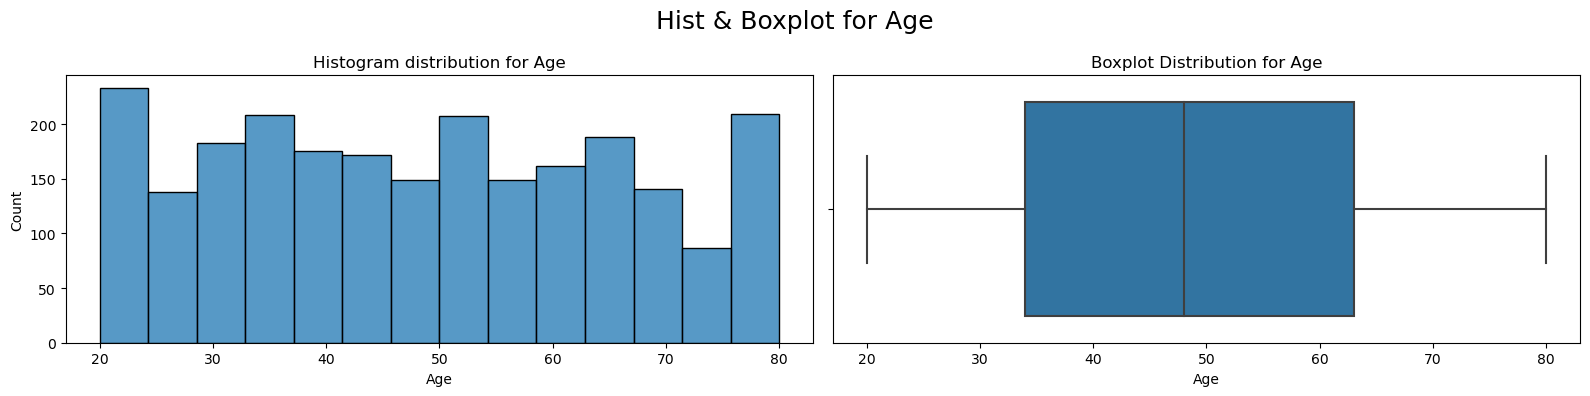

In [26]:
numdata(df, 'Age')

Age looks good. No outliers

Statistical Description: 
 count    2401.000000
mean     4005.253940
std      2881.128031
min       300.000000
25%      1600.000000
50%      3500.000000
75%      6200.000000
max      9000.000000
Name: Income, dtype: float64 



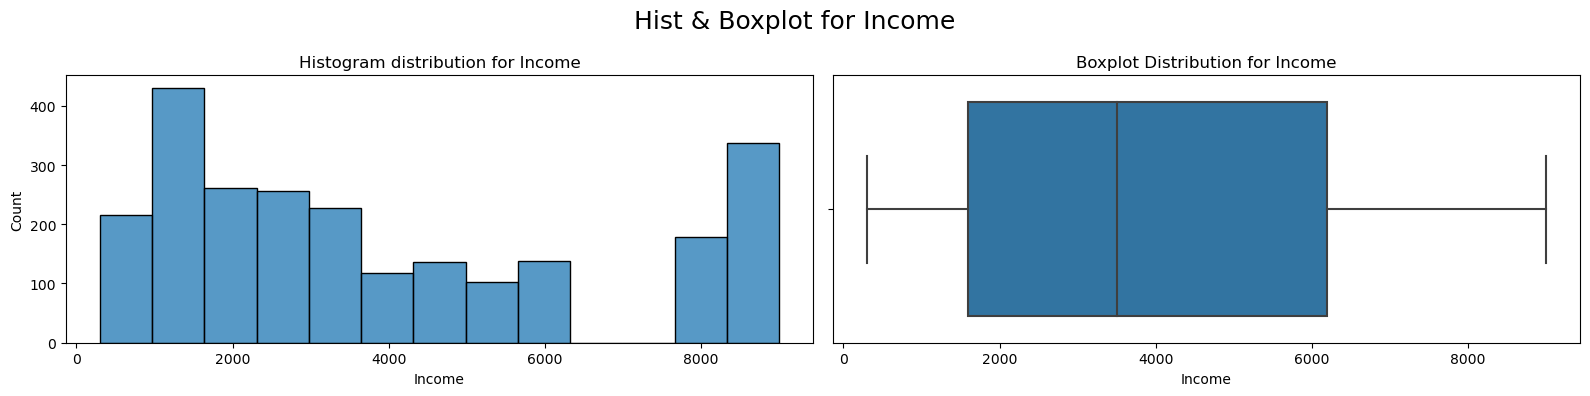

In [27]:
numdata(df, 'Income')

Income is good with no Outliers

Statistical Description: 
 count    2401.000000
mean       98.307254
std        15.962233
min        56.200000
25%        87.000000
50%        97.500000
75%       107.200000
max       176.000000
Name: WaistCirc, dtype: float64 



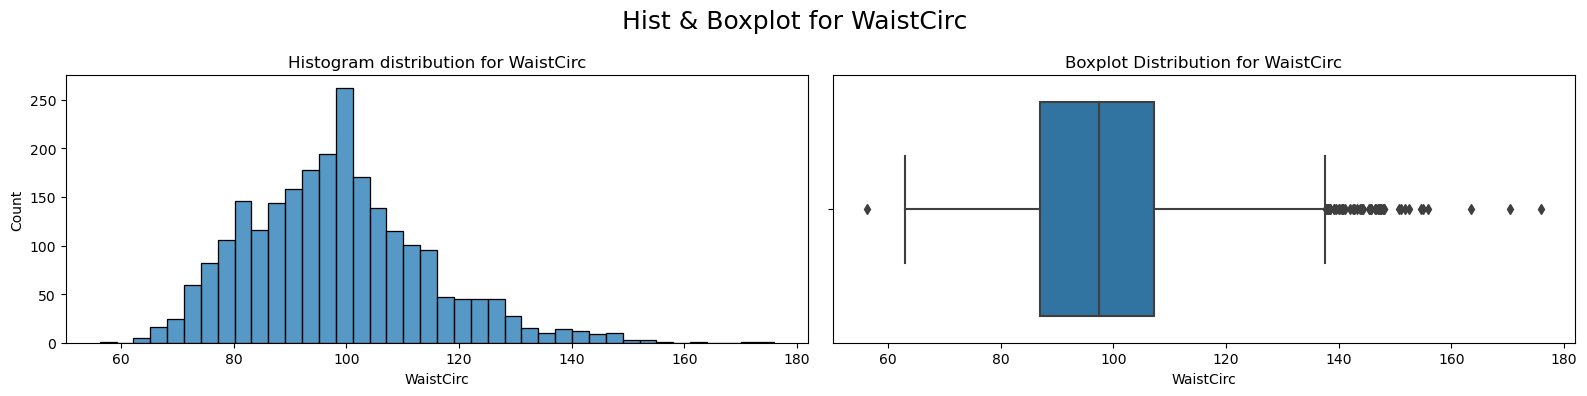

In [28]:
numdata(df, 'WaistCirc')

WaistCirc has some outliers. Lets fix that with the function I created earlier

Statistical Description: 
 count    2401.000000
mean       98.130369
std        15.430587
min        56.700000
25%        87.000000
50%        97.500000
75%       107.200000
max       137.500000
Name: WaistCirc, dtype: float64 



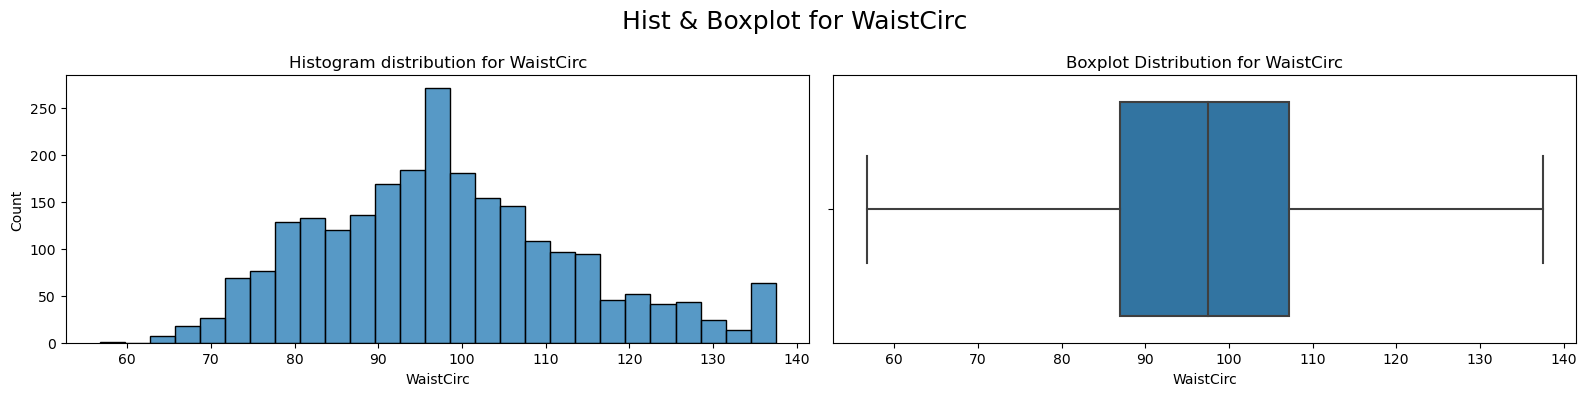

In [29]:
replace_outliers(df, ['WaistCirc'])
numdata(df,'WaistCirc')

Statistical Description: 
 count    2401.000000
mean       28.702189
std         6.626057
min        13.400000
25%        24.000000
50%        27.800000
75%        32.000000
max        68.700000
Name: BMI, dtype: float64 



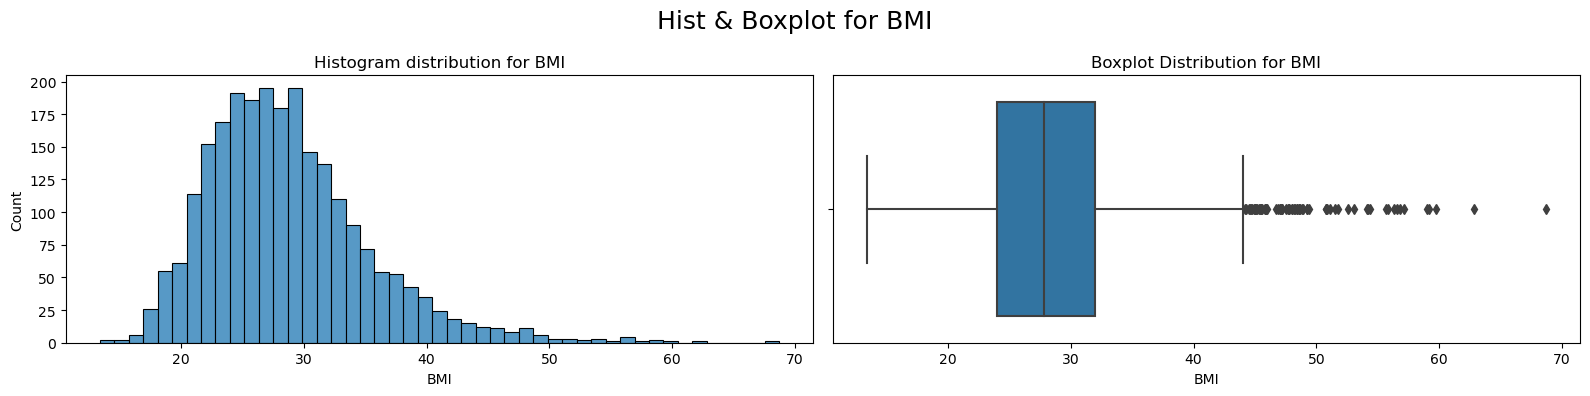

In [30]:
numdata(df, 'BMI')

BMI has some outliers, lets clean them up

Statistical Description: 
 count    2401.000000
mean       28.543672
std         6.118412
min        13.400000
25%        24.000000
50%        27.800000
75%        32.000000
max        44.000000
Name: BMI, dtype: float64 



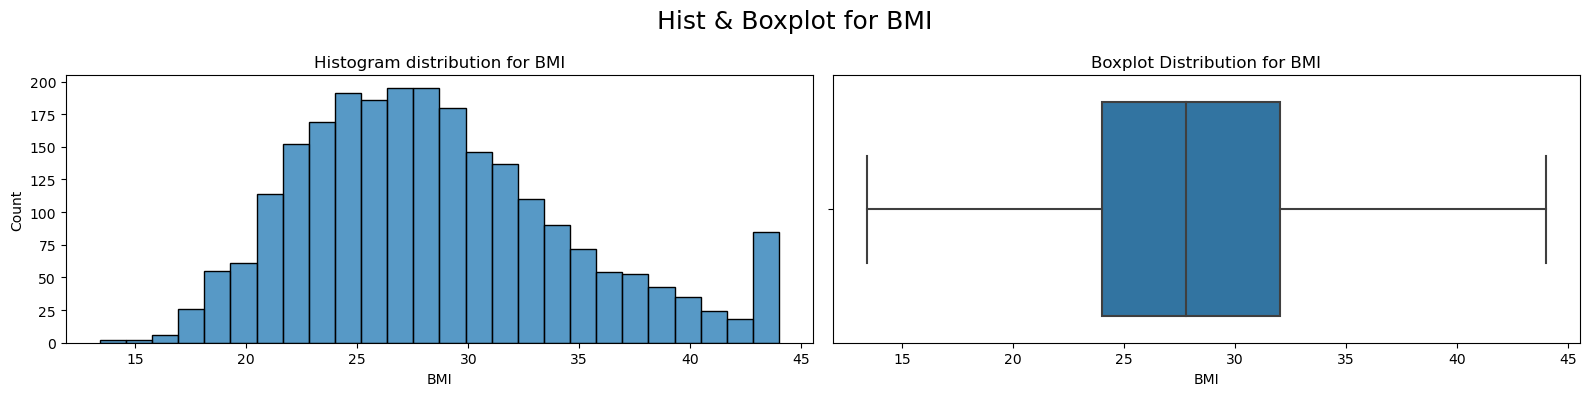

In [31]:
replace_outliers(df, ['BMI'])
numdata(df, 'BMI')

Statistical Description: 
 count    2401.000000
mean        0.154102
std         0.422780
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.000000
Name: Albuminuria, dtype: float64 



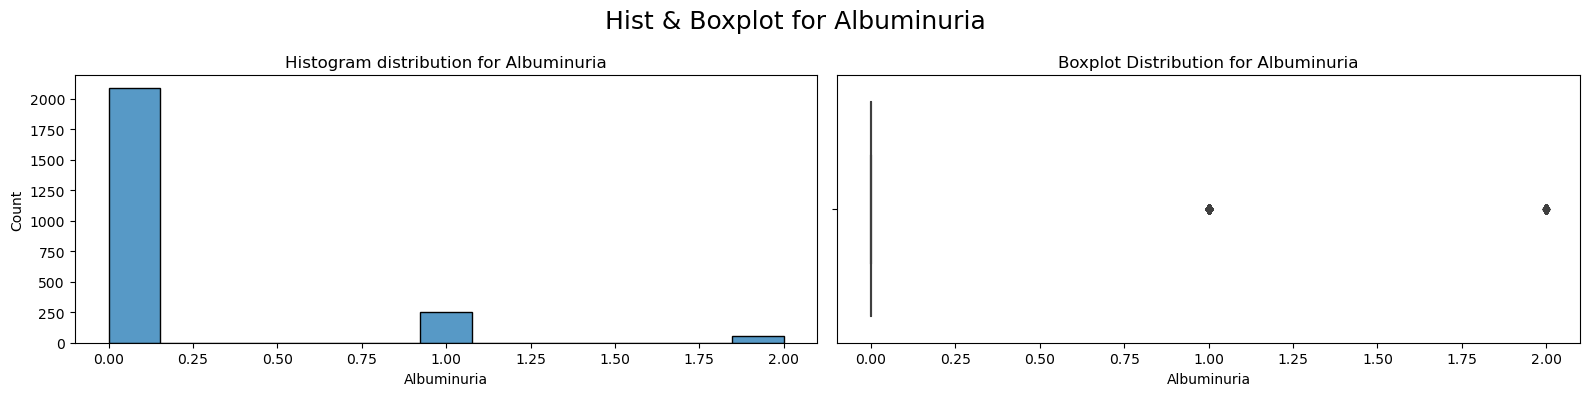

In [32]:
numdata(df, 'Albuminuria')

This column does not appear to actually be a numeric column. Albuminuria is a condition where the protein albumin is abnormally present in the urine. Lets run a value count on this instead

In [33]:
df['Albuminuria'].value_counts()

0    2089
1     254
2      58
Name: Albuminuria, dtype: int64

There is no description on this column in the data source, so I will make an assumption that this column is categorical column. According to [kidney.org](https://www.kidney.org/content/kidney-failure-risk-factor-urine-albumin-to-creatinine-ration-uacr) Albuminuria comes in 3 categories. I will confirm these categories by comparing this value to UrAlbCr, which I believe may be the Albumin-Creatinine Ratio

0    2089
1     254
2      58
Name: Albuminuria, dtype: int64

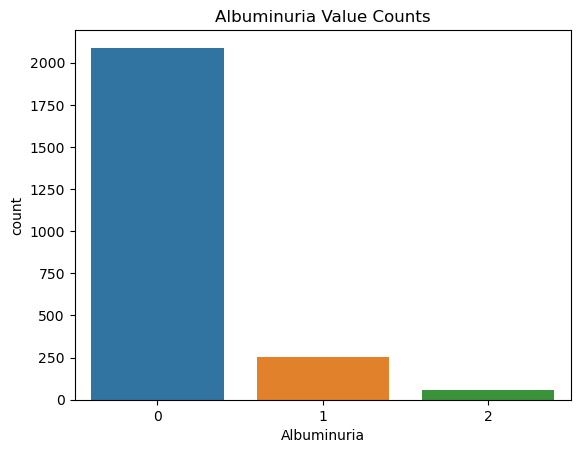

In [34]:
display(df['Albuminuria'].value_counts())
sns.countplot(data = df, x = 'Albuminuria').set(title = 'Albuminuria Value Counts');

Statistical Description: 
 count    2401.000000
mean       43.626131
std       258.272829
min         1.400000
25%         4.450000
50%         7.070000
75%        13.690000
max      5928.000000
Name: UrAlbCr, dtype: float64 



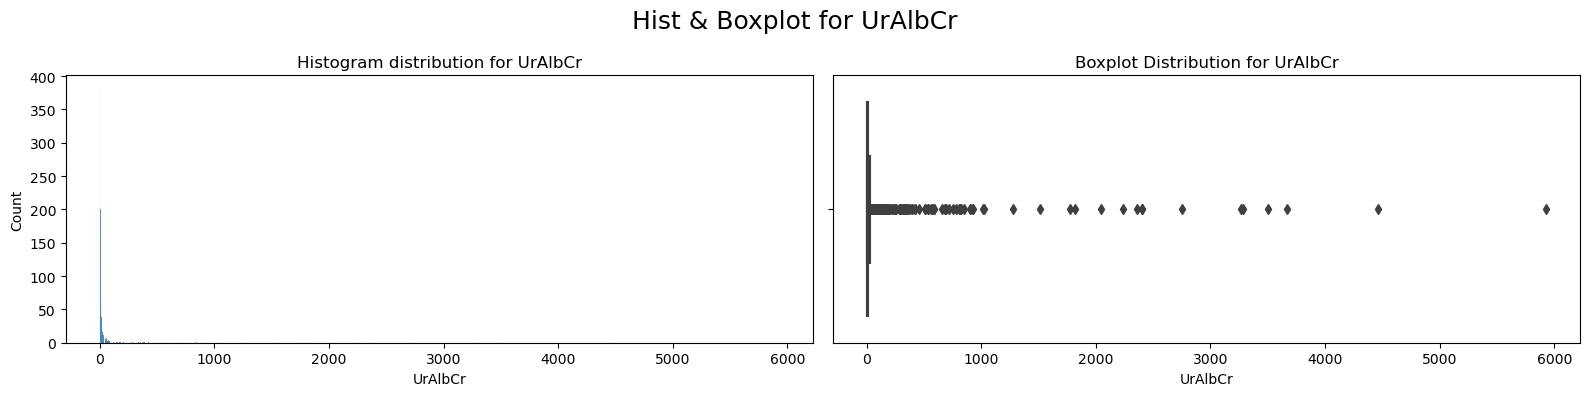

In [35]:
numdata(df, 'UrAlbCr')

Based on some research, I think UrAlbCr must be the Urine Albumin-Creatinine Ratio. I am going to dig into this to make sure this hypothesis is atleast plausible in the data. I want to check if Albuminuria categories match the UrAlbCr numbers. It should be:
* Albuminuria = 0 is < 30
* Albuminuria = 1 is < 300
* Albuminuria = 2 is > 300

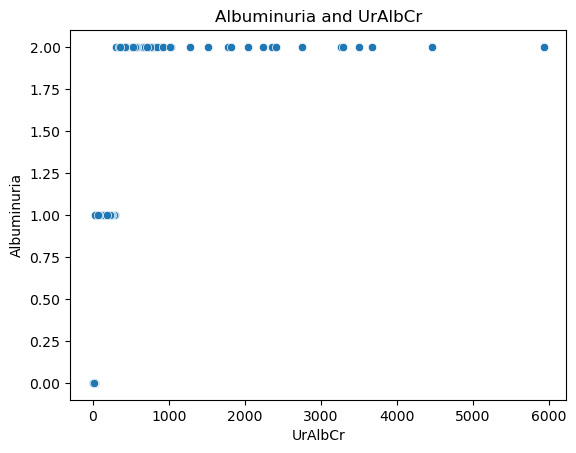

In [36]:
sns.scatterplot(data=df,x='UrAlbCr',y='Albuminuria').set(title='Albuminuria and UrAlbCr');

In [37]:
print('Albuminuria = 0 \n')
display(df.loc[(df['Albuminuria'] == 0),'UrAlbCr'].describe())
print('Albuminuria = 1 \n')
display(df.loc[(df['Albuminuria'] == 1),'UrAlbCr'].describe())
print('Albuminuria = 2 \n')
display(df.loc[(df['Albuminuria'] == 2),'UrAlbCr'].describe())

Albuminuria = 0 



count    2089.000000
mean        8.100282
std         5.688320
min         1.400000
25%         4.190000
50%         6.240000
75%        10.060000
max        29.820000
Name: UrAlbCr, dtype: float64

Albuminuria = 1 



count    254.000000
mean      74.751496
std       53.439890
min       30.000000
25%       37.742500
50%       53.685000
75%       90.447500
max      289.720000
Name: UrAlbCr, dtype: float64

Albuminuria = 2 



count      58.000000
mean     1186.861552
std      1189.233401
min       301.050000
25%       421.935000
50%       686.735000
75%      1452.482500
max      5928.000000
Name: UrAlbCr, dtype: float64

This is correct. Albuminuria is an Ordinal column and it matches the values we should expect to see. I will not fix any outliers for UrAlbCr since it is part of an ordinal column

Statistical Description: 
 count    2401.000000
mean        5.489046
std         1.439358
min         1.800000
25%         4.500000
50%         5.400000
75%         6.400000
max        11.300000
Name: UricAcid, dtype: float64 



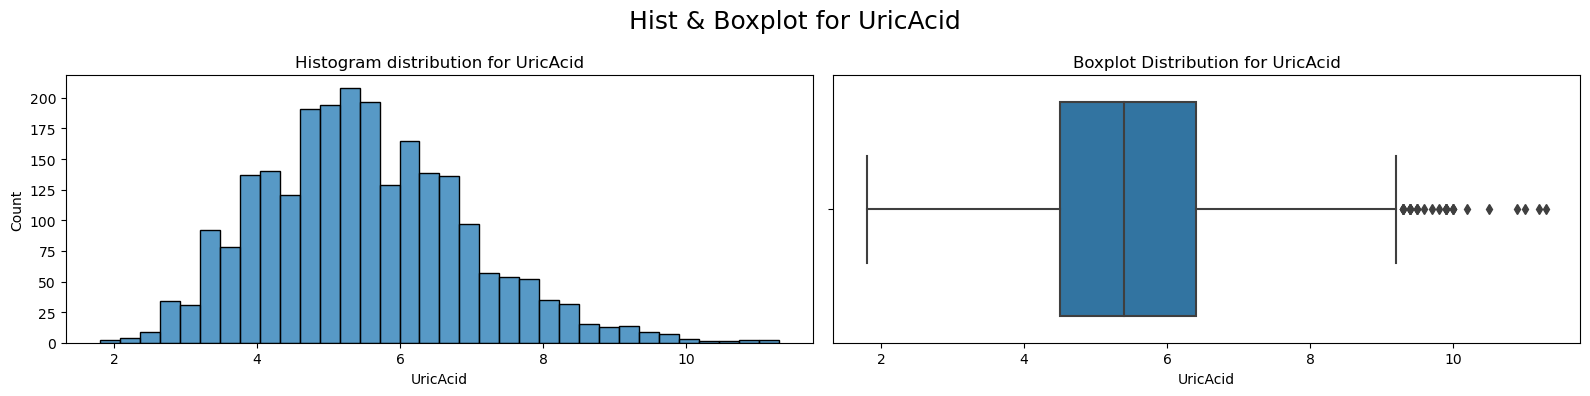

In [38]:
numdata(df, 'UricAcid')

Uric Acid has some outliers with a tight distribution. [MedicalNewsToday](https://www.medicalnewstoday.com/articles/uric-acid-level#uric-acid-levels) High Uric Acid is above 7 for Males and above 6 for Females. Lets replace the outliers.

Statistical Description: 
 count    2401.000000
mean        5.481466
std         1.416299
min         1.800000
25%         4.500000
50%         5.400000
75%         6.400000
max         9.250000
Name: UricAcid, dtype: float64 



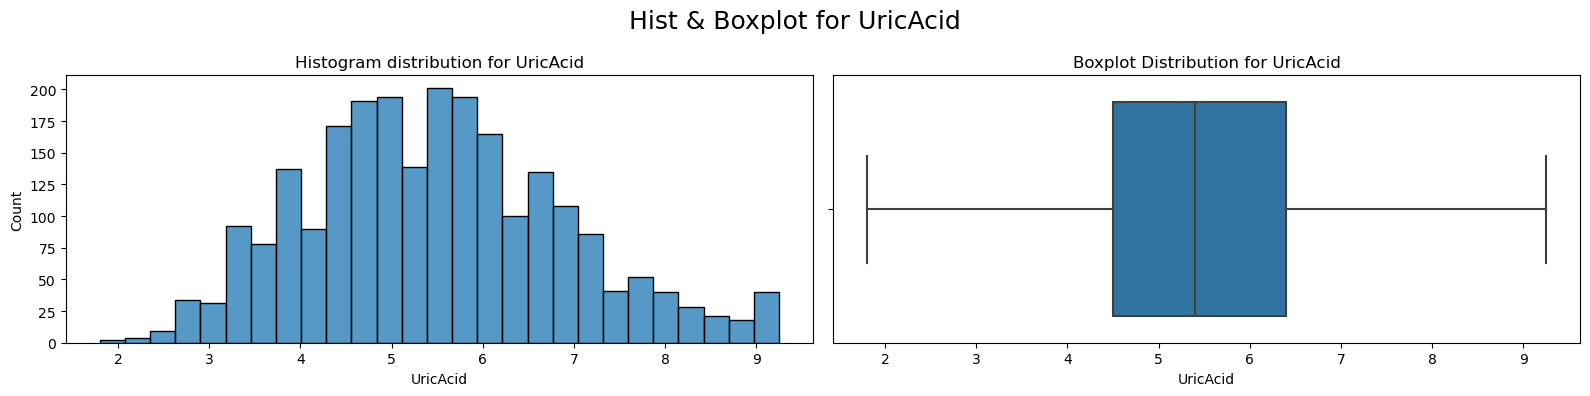

In [39]:
replace_outliers(df, ['UricAcid'])
numdata(df, 'UricAcid')

Statistical Description: 
 count    2401.000000
mean      108.247813
std        34.820657
min        39.000000
25%        92.000000
50%        99.000000
75%       110.000000
max       382.000000
Name: BloodGlucose, dtype: float64 



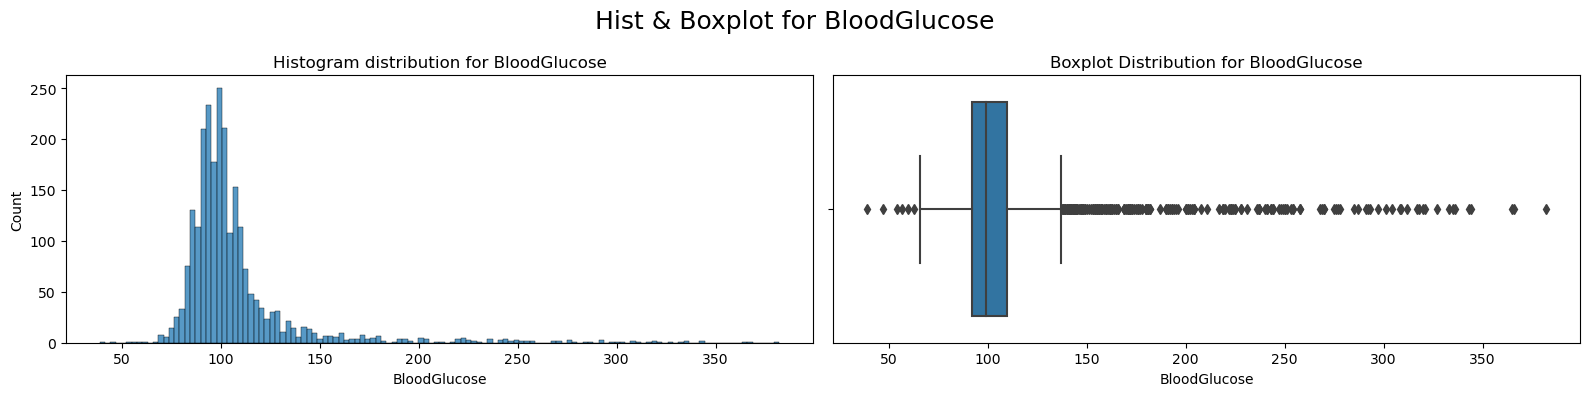

In [40]:
numdata(df, 'BloodGlucose')

In [41]:
top, bottom = get_outliers(df, 'BloodGlucose')
print(top)
df.loc[df['BloodGlucose'] > top,'BloodGlucose'].shape[0]

137.0


214

According to [Forbes health](https://www.forbes.com/health/body/normal-blood-sugar-levels/) normal fasting blood sugar levels are less than or equal to 100mg/dl. There is no info on the dataset about the unit of measure or time of measurement for BloodGlucose, I will assume that it is fasted BloodGlucose. There are outliers in this data. It makes up about 9% of the data on the high end. I will standardize these outliers, but it might make sense to create categories for this datapoint instead. For now, lets standardize

Statistical Description: 
 count    2401.000000
mean      102.908788
std        15.740037
min        65.000000
25%        92.000000
50%        99.000000
75%       110.000000
max       137.000000
Name: BloodGlucose, dtype: float64 



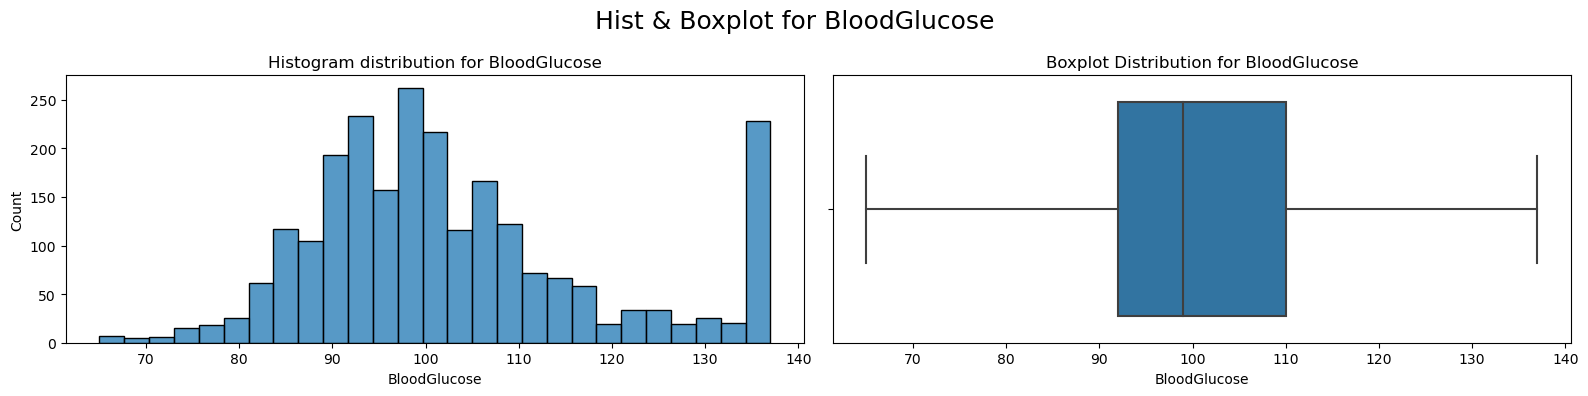

In [42]:
replace_outliers(df, ['BloodGlucose'])
numdata(df, 'BloodGlucose')

Statistical Description: 
 count    2401.000000
mean       53.369429
std        15.185537
min        14.000000
25%        43.000000
50%        51.000000
75%        62.000000
max       156.000000
Name: HDL, dtype: float64 



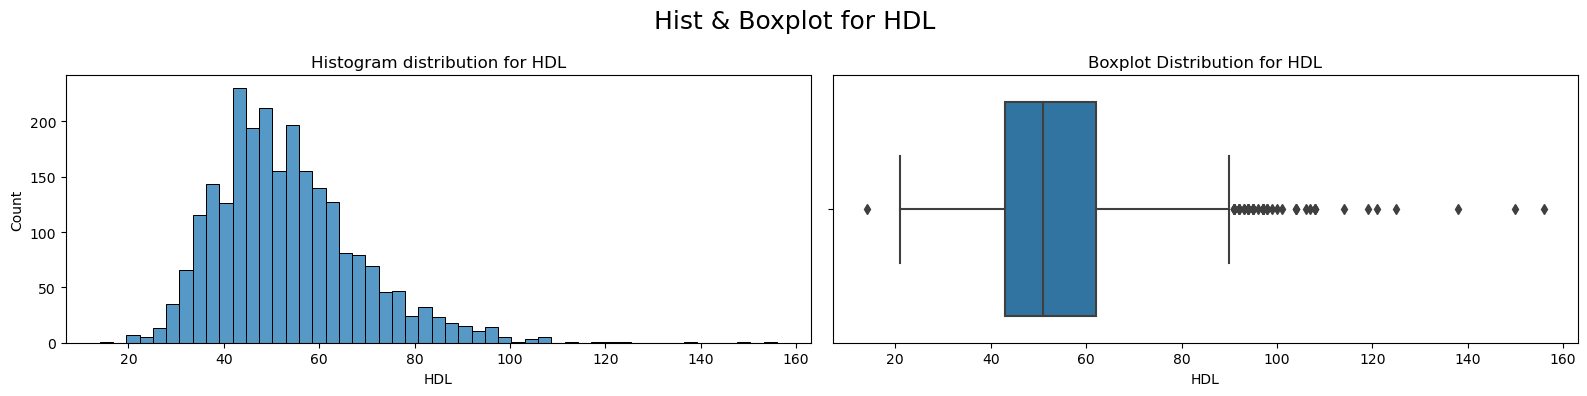

In [43]:
numdata(df, 'HDL')

Some outliers here as well, lets fix them. HDL behaves differently than other measures here. For HDL, a higher number is better. Here, a healthy adult should be at 60, but no less than 50 for Women and 40 for Men. Source: [MayoClinic](https://www.mayoclinic.org/diseases-conditions/high-blood-cholesterol/in-depth/hdl-cholesterol/art-20046388). The mean is right around that 50 mark, and our IQR sits right around the healthy levels. 

Statistical Description: 
 count    2401.000000
mean       53.129946
std        14.346950
min        14.500000
25%        43.000000
50%        51.000000
75%        62.000000
max        90.500000
Name: HDL, dtype: float64 



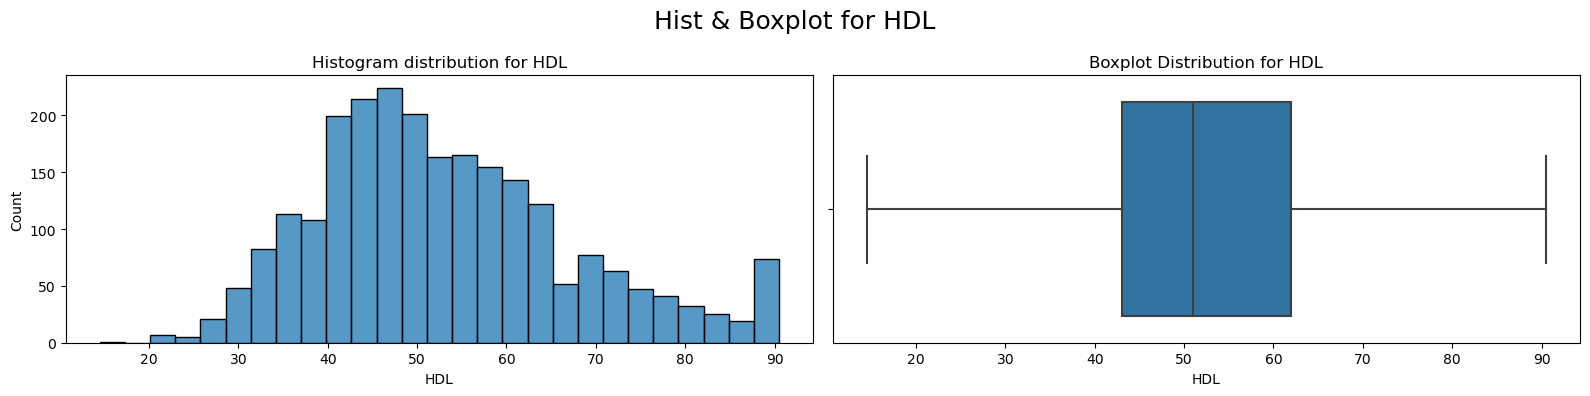

In [44]:
replace_outliers(df, ['HDL'])
numdata(df, 'HDL')

Statistical Description: 
 count    2401.000000
mean      128.125364
std        95.322477
min        26.000000
25%        75.000000
50%       103.000000
75%       150.000000
max      1562.000000
Name: Triglycerides, dtype: float64 



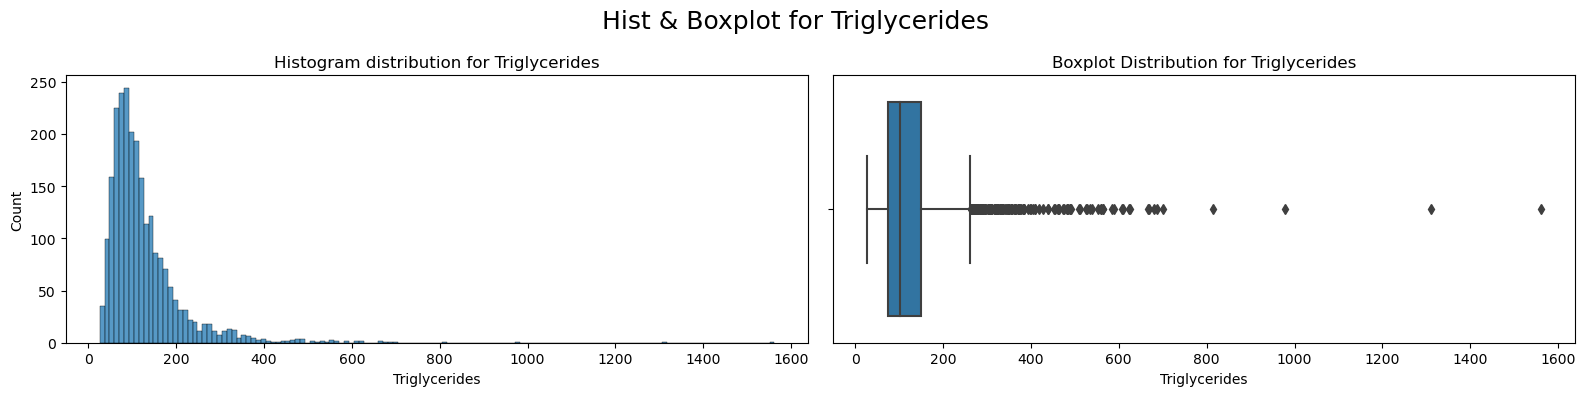

In [45]:
numdata(df,'Triglycerides')

In [46]:
top, bottom = get_outliers(df, 'Triglycerides')
top

262.5

Triglycerides have ranges, I would like to create some categories for this column instead of standardizing. the High outliers for the dataset start at 262.5, while Very High triglycerides are considered to be over 500. I will use the categories from [MayoClinic](https://www.mayoclinic.org/diseases-conditions/high-blood-cholesterol/in-depth/triglycerides/art-20048186) for my analysis

In [47]:
df.loc[(df['Triglycerides']<150),'TriglyceridesCat'] = 0
df.loc[(df['Triglycerides']>=150) & (df['Triglycerides']<200),'TriglyceridesCat'] = 1
df.loc[(df['Triglycerides']>=200) & (df['Triglycerides']<500),'TriglyceridesCat'] = 2
df.loc[(df['Triglycerides']>=500),'TriglyceridesCat'] = 3

In [48]:
df['TriglyceridesCat'].value_counts()

0.0    1800
1.0     309
2.0     266
3.0      26
Name: TriglyceridesCat, dtype: int64

### Categorical
This concludes our Numerical Data. Now lets take a look at Categorical, including Ordinal

Count of Values: 
0.0    1800
1.0     309
2.0     266
3.0      26
Name: TriglyceridesCat, dtype: int64 

Statistical Description: 
 count    2401.000000
mean        0.382757
std         0.723201
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         3.000000
Name: TriglyceridesCat, dtype: float64


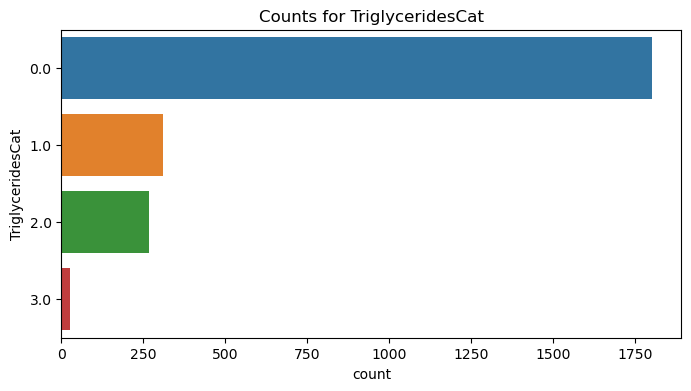

In [49]:
catdata(df, 'TriglyceridesCat')

Count of Values: 
0    1579
1     822
Name: MetabolicSyndrome, dtype: int64 

Statistical Description: 
 count    2401.000000
mean        0.342357
std         0.474597
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: MetabolicSyndrome, dtype: float64


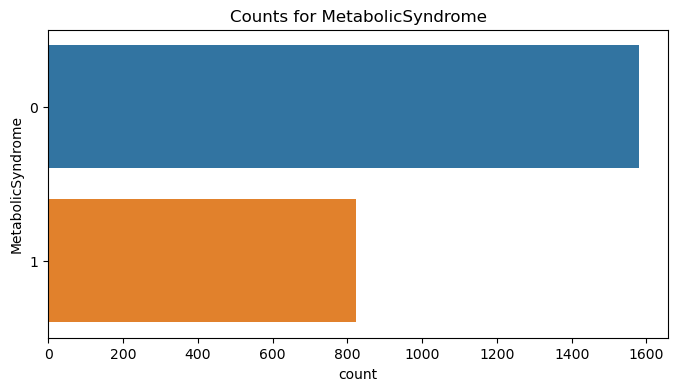

In [50]:
catdata(df, 'MetabolicSyndrome')

Count of Values: 
Female    1211
Male      1190
Name: Sex, dtype: int64 

Statistical Description: 
 count       2401
unique         2
top       Female
freq        1211
Name: Sex, dtype: object


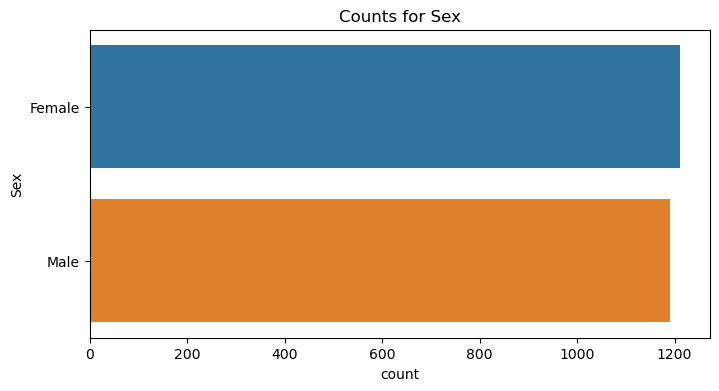

In [51]:
catdata(df, 'Sex')

Consistent values, we see that there is a good balance between Male and Female, althought we have slightly more Females than Males in the dataset

Count of Values: 
Married      1192
Single        498
Divorced      242
Unknown       208
Widowed       166
Separated      95
Name: Marital, dtype: int64 

Statistical Description: 
 count        2401
unique          6
top       Married
freq         1192
Name: Marital, dtype: object


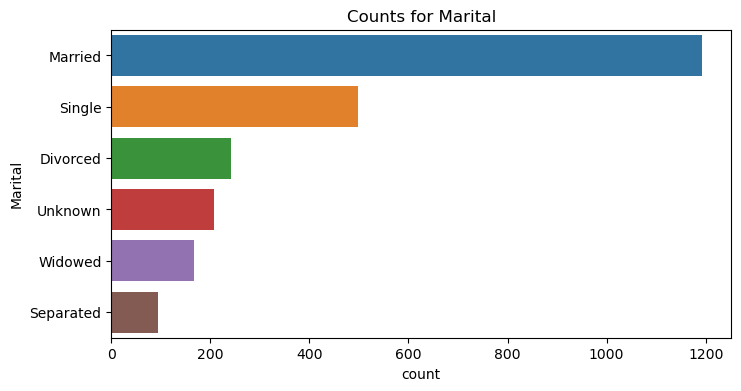

In [52]:
catdata(df, 'Marital')

Consistent, We reviewed this column when cleaning for empty values

Count of Values: 
White          933
Black          548
Asian          349
Hispanic       257
MexAmerican    253
Other           61
Name: Race, dtype: int64 

Statistical Description: 
 count      2401
unique        6
top       White
freq        933
Name: Race, dtype: object


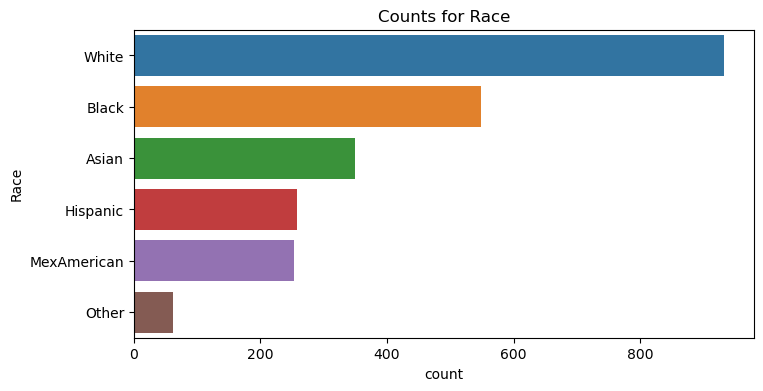

In [53]:
catdata(df, 'Race')

This column is consistent. The dataset is comprised mainly of White people. MexAmerican is an odd category, it might make sense to combine it into Hispanic. But I will leave it for now.

# Explanatory Data Analysis
In this section I will look through the data and find trends and correlations between my features, and my target

C:\Users\Ray\AppData\Local\Temp\ipykernel_8920\236164521.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


<AxesSubplot: >

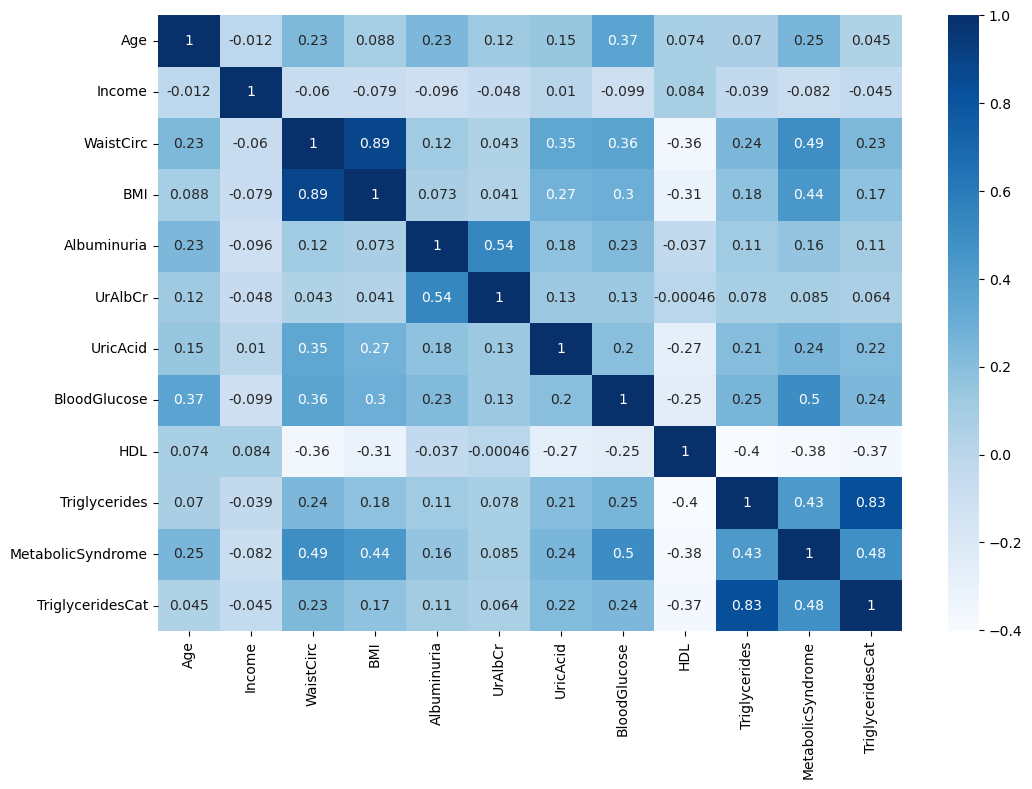

In [54]:
corr = df.corr()
fig, ax = plt.subplots(figsize = (12,8))
sns.heatmap(corr, annot = True, cmap = 'Blues')

We will use this heatmap as a jumping off point for this analysis. Here we can see that:

**Target:**
* MetabolicSyndrome, our target, has some correlation with Age, WaistCirc, BMI, UricAcid, BloodGlucose, HDL, and Triglycerides
* I will mostly focus my analysis on the relationships above

**Features:**
* A lot of features have some correlation, I will mainly focus on:
    * WaistCirc and BMI
    * HDL and Triglycerides

## WaistCirc and BMI

### Presentable Visual

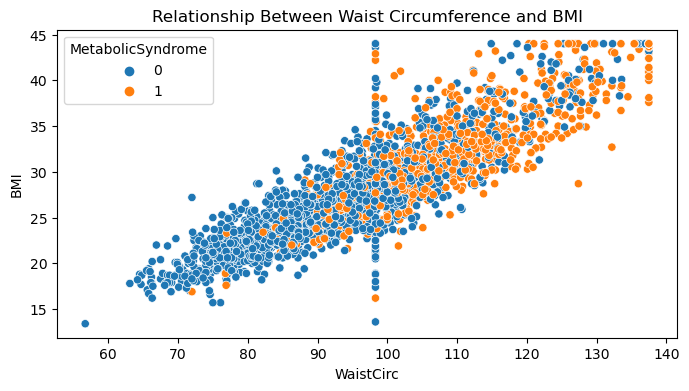

In [55]:
fig, ax = plt.subplots(figsize = (8,4))
sns.scatterplot(data = df, x = 'WaistCirc', y = 'BMI', hue = 'MetabolicSyndrome', ax = ax)
ax.set_title('Relationship Between Waist Circumference and BMI');

* Due to my data cleaning earlier, we see that there are a grouping of values for WaistCirc around 100, and that both WaistCirc and BMI have a ceiling value
* The graph above shows that there is a correlation between BMI and WaistCirc. There also appears to be a strong correlation with WaistCirc AND BMI combined, and MetabolicSyndrome.
* This correlation is so strong that I will need to keep an eye out for it once I begin to fit a model to the data

## HDL and Triglycerides

### Presentable Visual

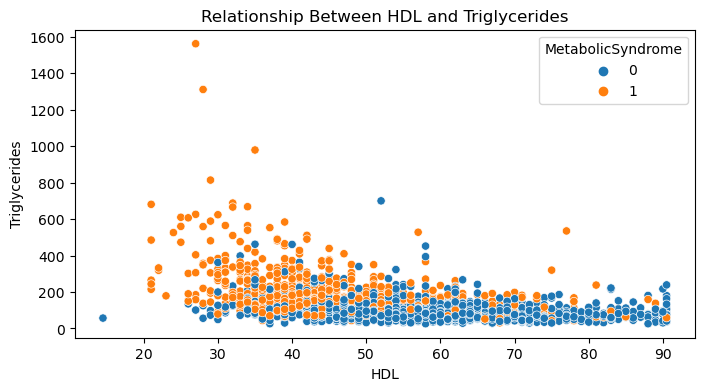

In [56]:
fig, ax = plt.subplots(figsize = (8,4))
sns.scatterplot(data = df, x = 'HDL', y = 'Triglycerides', hue = 'MetabolicSyndrome', ax = ax)
ax.set_title('Relationship Between HDL and Triglycerides');

* The graph above shows that there is a weak negative correlation between Triglycerides and HDL. And in general, people with higher HDL and lower Triglycerides have less MetabolicSyndrome

## MetabolicSyndrome and Age

### Presentable Visual

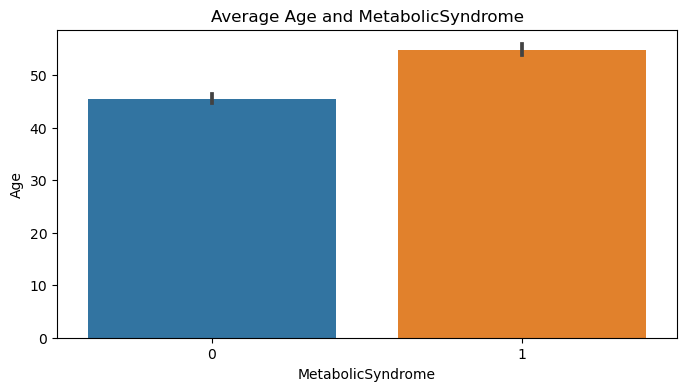

In [57]:
fig, ax = plt.subplots(figsize = (8,4))
sns.barplot(data = df, y = 'Age', x = 'MetabolicSyndrome', ax = ax)
ax.set_title('Average Age and MetabolicSyndrome');

* The graph above shows that the average Age for someone with MetabolicSyndrome VS. someone without MetabolicSyndrome is higher. This points to a positive relationship between Age and MetabolicSyndrome

## MetabolicSyndrome and WaistCirc

### Presentable Visual

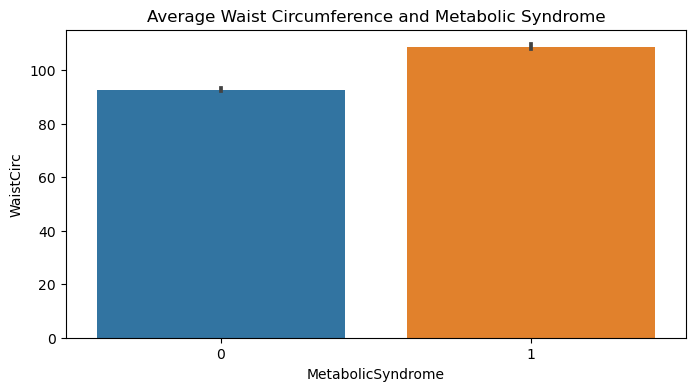

In [58]:
fig, ax = plt.subplots(figsize = (8,4))
sns.barplot(data = df, y = 'WaistCirc', x = 'MetabolicSyndrome', ax = ax)
ax.set_title('Average Waist Circumference and Metabolic Syndrome');

* The graph above shows that the average Waist Circumference for someone with MetabolicSyndrome VS. someone without MetabolicSyndrome is higher. This points to a positive relationship between Waist Circumference and MetabolicSyndrome

## MetabolicSyndrome and BMI

### Presentable Visual

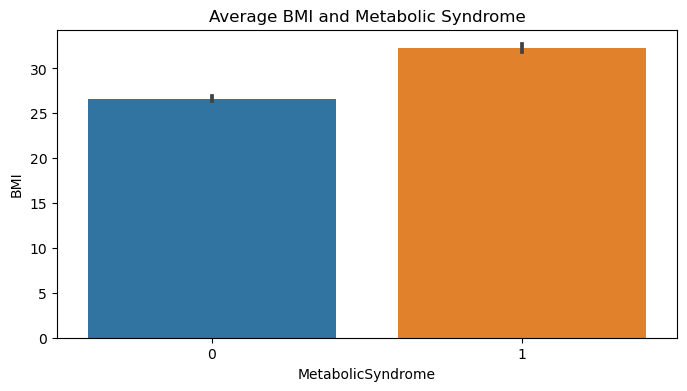

In [59]:
fig, ax = plt.subplots(figsize = (8,4))
sns.barplot(data = df, y = 'BMI', x = 'MetabolicSyndrome', ax = ax)
ax.set_title('Average BMI and Metabolic Syndrome');

* The graph above shows that the average BMI for someone with MetabolicSyndrome VS. someone without MetabolicSyndrome is higher. This points to a positive relationship between BMI and MetabolicSyndrome

## MetabolicSyndrome and UricAcid

### Presentable Visual

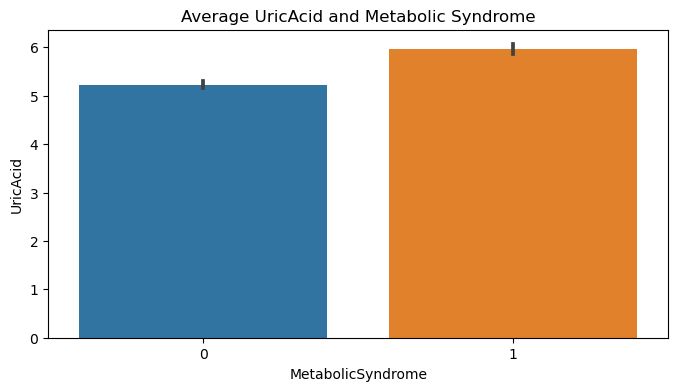

In [60]:
fig, ax = plt.subplots(figsize = (8,4))
sns.barplot(data = df, y = 'UricAcid', x = 'MetabolicSyndrome', ax = ax)
ax.set_title('Average UricAcid and Metabolic Syndrome');

* The graph above shows that the average UricAcid for someone with MetabolicSyndrome VS. someone without MetabolicSyndrome is higher. This points to a positive relationship between UricAcid and MetabolicSyndrome

## MetabolicSyndrome and BloodGlucose

### Presentable Visual

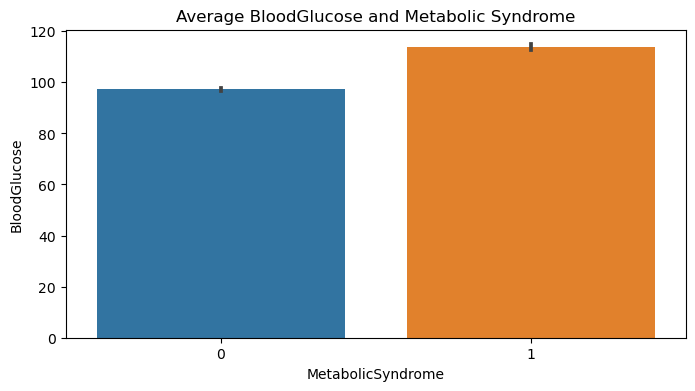

In [61]:
fig, ax = plt.subplots(figsize = (8,4))
sns.barplot(data = df, y = 'BloodGlucose', x = 'MetabolicSyndrome', ax = ax)
ax.set_title('Average BloodGlucose and Metabolic Syndrome');

* The graph above shows that the average BloodGlucose for someone with MetabolicSyndrome VS. someone without MetabolicSyndrome is higher. This points to a positive relationship between BloodGlucose and MetabolicSyndrome

## MetabolicSyndrome and HDL

### Presentable Visual

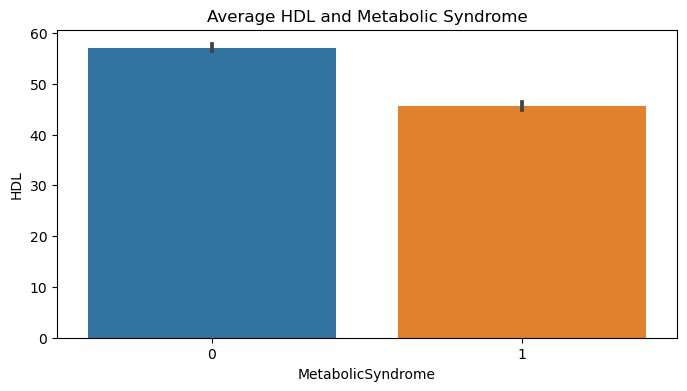

In [62]:
fig, ax = plt.subplots(figsize = (8,4))
sns.barplot(data = df, y = 'HDL', x = 'MetabolicSyndrome', ax = ax)
ax.set_title('Average HDL and Metabolic Syndrome');

* The graph above shows that the average HDL for someone with MetabolicSyndrome VS. someone without MetabolicSyndrome is lower. This points to an inverse relationship, or a negative correlation, between HDL and MetabolicSyndrome

## MetabolicSyndrome and Triglycerides

### Presentable Visual

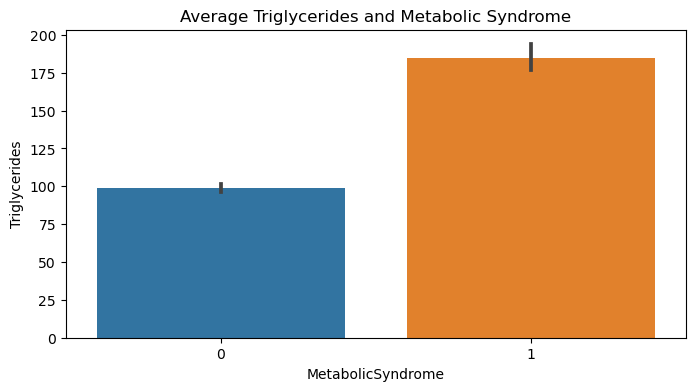

In [63]:
fig, ax = plt.subplots(figsize = (8,4))
sns.barplot(data = df, y = 'Triglycerides', x = 'MetabolicSyndrome', ax = ax)
ax.set_title('Average Triglycerides and Metabolic Syndrome');

* The graph above shows that the average Triglycerides for someone with MetabolicSyndrome VS. someone without MetabolicSyndrome is higher. This points to a positive relationship between Triglycerides and MetabolicSyndrome

# Machine Learning
From here I'll start creating my preprocessors for ML and some models.

## Scoring Functions
This is a binary classification problem, so I will load some functions to score classification models

In [64]:
def model_eval(model, X_train, y_train, X_test, y_test, name = 'model', cmap='Blues',
               normalize=None, zero_division=0, figsize=(20,12)):
    '''This function takes the model pipeline, the training and testing data, and the
    model name. It then prints a classification report for the testing and training data
    and plots a confusion matrix and ROC curve for both training and testing. It also 
    returns Accuracy, Recall, Precision, and F1 in a dataframe.'''
    # Store predictions
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    train_proba = model.predict_proba(X_train)[:,1]
    test_proba = model.predict_proba(X_test)[:,1]
    
    # Classification Reports
    print('--------TRAINING SET METRICS--------')
    print(classification_report(y_train, train_preds, zero_division=zero_division))
    
    print('--------TESTING SET METRICS--------')
    print(classification_report(y_test, test_preds, zero_division=zero_division))
    
    # Plots
    fig, ax = plt.subplots(ncols = 2, nrows = 2, figsize=figsize)
    
    ConfusionMatrixDisplay.from_predictions(y_train, train_preds, normalize=normalize, 
                                            cmap=cmap, ax=ax[0,0])
    ax[0,0].set_title('Training Data Confusion Matrix')
    
    ConfusionMatrixDisplay.from_predictions(y_test, test_preds, normalize=normalize, 
                                            cmap=cmap, ax=ax[0,1])
    ax[0,1].set_title('Testing Data Confusion Matrix')
    
    RocCurveDisplay.from_predictions(y_train, train_proba, ax=ax[1,0])
    ax[1,0].set_title('Training Data ROC Curve')
    
    RocCurveDisplay.from_predictions(y_test, test_proba,ax=ax[1,1])
    ax[1,1].set_title('Testing Data ROC Curve')
    
    # Storing the scores in a dataframe.
    scores = pd.DataFrame()
    
    # Training
    scores.loc[name, 'Train Accuracy'] = accuracy_score(y_train, train_preds)
    scores.loc[name, 'Train Recall'] = recall_score(y_train, train_preds, 
                                                    zero_division=zero_division)
    scores.loc[name, 'Train Precision'] = precision_score(y_train, train_preds,
                                                          zero_division=zero_division)
    scores.loc[name, 'Train F1'] = f1_score(y_train, train_preds, 
                                            zero_division=zero_division)
    
    # Testing
    scores.loc[name, 'Test Accuracy'] = accuracy_score(y_test, test_preds)
    scores.loc[name, 'Test Recall'] = recall_score(y_test, test_preds, 
                                                   zero_division=zero_division)
    scores.loc[name, 'Test Precision'] = precision_score(y_test, test_preds,
                                                         zero_division=zero_division)
    scores.loc[name, 'Test F1'] = f1_score(y_test, test_preds, 
                                           zero_division=zero_division)
    
    return scores

## Preprocessor
I am going to make one preprocessor that takes the dataframe and creates a numpy array for modeling. Also, because this data has unbalanced targets, I will use SMOTE to balance out the training data.

I have some missing values that must be imputed:
* Categorical:
    * Marital
        * I will fill the nulls with a constant 'unknown'
* Numerical
    * BMI, WaistCirc, Income
        * I will fill the rest of my numerical columns with the mean, as I did earlier in my data cleaning section

In [65]:
# Imputers
mean_imputer = SimpleImputer(strategy = 'mean')
const_imputer = SimpleImputer(strategy = 'constant', fill_value = 'Unknown')

# Scaler and OHE
ohe = OneHotEncoder(handle_unknown = 'ignore', sparse = False)
scaler = StandardScaler()

# Pipelines for imputers and transformers
num_pipe = make_pipeline(mean_imputer, scaler)
cat_pipe = make_pipeline(const_imputer, ohe)

# Column Selectors
num_cols = make_column_selector(dtype_include='number')
cat_cols = make_column_selector(dtype_include = 'object')

# Tuples
num_tuple = (num_pipe, num_cols)
cat_tuple = (cat_pipe, cat_cols)

# Preprocessor
preprocessor = make_column_transformer(num_tuple, cat_tuple, remainder = 'drop')

# SMOTE
smote = SMOTE(random_state = 42)


My preprocessor is complete. I have an instance of SMOTE ready to go as well. When I start modeling, I will create a pipeline that goes as follows: (preprocessor, smote, model). Now i need to split my data into train and test. Before I can do this, I need to start with a fresh dataset and create my feature matrix and my target vector

## Data Splits

In [66]:
dfml = data.copy()

In [67]:
dfml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2401 entries, 0 to 2400
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   seqn               2401 non-null   int64  
 1   Age                2401 non-null   int64  
 2   Sex                2401 non-null   object 
 3   Marital            2193 non-null   object 
 4   Income             2284 non-null   float64
 5   Race               2401 non-null   object 
 6   WaistCirc          2316 non-null   float64
 7   BMI                2375 non-null   float64
 8   Albuminuria        2401 non-null   int64  
 9   UrAlbCr            2401 non-null   float64
 10  UricAcid           2401 non-null   float64
 11  BloodGlucose       2401 non-null   int64  
 12  HDL                2401 non-null   int64  
 13  Triglycerides      2401 non-null   int64  
 14  MetabolicSyndrome  2401 non-null   object 
dtypes: float64(5), int64(6), object(4)
memory usage: 281.5+ KB


In [68]:
dfml['MetabolicSyndrome'].replace({'No MetSyn':0,'MetSyn':1}, inplace = True)
dfml.drop(columns = ['seqn'], inplace = True)
dfml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2401 entries, 0 to 2400
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                2401 non-null   int64  
 1   Sex                2401 non-null   object 
 2   Marital            2193 non-null   object 
 3   Income             2284 non-null   float64
 4   Race               2401 non-null   object 
 5   WaistCirc          2316 non-null   float64
 6   BMI                2375 non-null   float64
 7   Albuminuria        2401 non-null   int64  
 8   UrAlbCr            2401 non-null   float64
 9   UricAcid           2401 non-null   float64
 10  BloodGlucose       2401 non-null   int64  
 11  HDL                2401 non-null   int64  
 12  Triglycerides      2401 non-null   int64  
 13  MetabolicSyndrome  2401 non-null   int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 262.7+ KB


In [69]:
X = dfml.drop('MetabolicSyndrome', axis = 1)
y = dfml['MetabolicSyndrome']

# Stratifying on y to keep the class imbalance consistent for train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1800, 13)
(1800,)
(601, 13)
(601,)


Now that we have our data split into train and test, we can handle outliers on the training data without any data leakage. I will use the function I built earlier to replace the outliers with the max outlier.

Columns to be fixed:
* WaistCirc
* BMI
* UricAcid
* BloodGlucose
* HDL

In [70]:
replace_outliers(X_train, column = ['WaistCirc','BMI','UricAcid','BloodGlucose','HDL'])

In [71]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1800 entries, 1352 to 891
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Age            1800 non-null   int64  
 1   Sex            1800 non-null   object 
 2   Marital        1647 non-null   object 
 3   Income         1712 non-null   float64
 4   Race           1800 non-null   object 
 5   WaistCirc      1739 non-null   float64
 6   BMI            1777 non-null   float64
 7   Albuminuria    1800 non-null   int64  
 8   UrAlbCr        1800 non-null   float64
 9   UricAcid       1800 non-null   float64
 10  BloodGlucose   1800 non-null   int64  
 11  HDL            1800 non-null   int64  
 12  Triglycerides  1800 non-null   int64  
dtypes: float64(5), int64(5), object(3)
memory usage: 196.9+ KB


We now have a training set thats ready to be processed and fed into models. **NOTE:** I have not done any feature engineering at this step. I want to run a set of models on the data prior to feature engineering to see if that engineering made any difference

## Models
For this data, I will fit a Logistic Regression, a RandomForest, and LightGBM. Lets start with the Logistic Regression.
Since this is a medical dataset, I want to maximize recall. Recall minimizes false negatives, and I dont want Metabolic Syndrome to go undiagnosed

### Logistic Regression

In [72]:
logbase = LogisticRegression(max_iter=1000, solver = 'liblinear')

# Logistic Pipeline
base_log_pipe = make_pipeline(preprocessor, smote, logbase)

In [73]:
base_log_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000011E8AF6BDC0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000011E8AF6BC40>)])),
                ('smote', SMOTE(random_state=42)),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, solver='liblinear'))])

--------TRAINING SET METRICS--------
              precision    recall  f1-score   support

           0       0.91      0.84      0.87      1184
           1       0.73      0.85      0.79       616

    accuracy                           0.84      1800
   macro avg       0.82      0.84      0.83      1800
weighted avg       0.85      0.84      0.84      1800

--------TESTING SET METRICS--------
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       395
           1       0.72      0.79      0.75       206

    accuracy                           0.82       601
   macro avg       0.80      0.81      0.81       601
weighted avg       0.83      0.82      0.82       601



,Train Accuracy,Train Recall,Train Precision,Train F1,Test Accuracy,Test Recall,Test Precision,Test F1
Base Log,0.841667,0.847403,0.732118,0.785553,0.821963,0.786408,0.72,0.75174


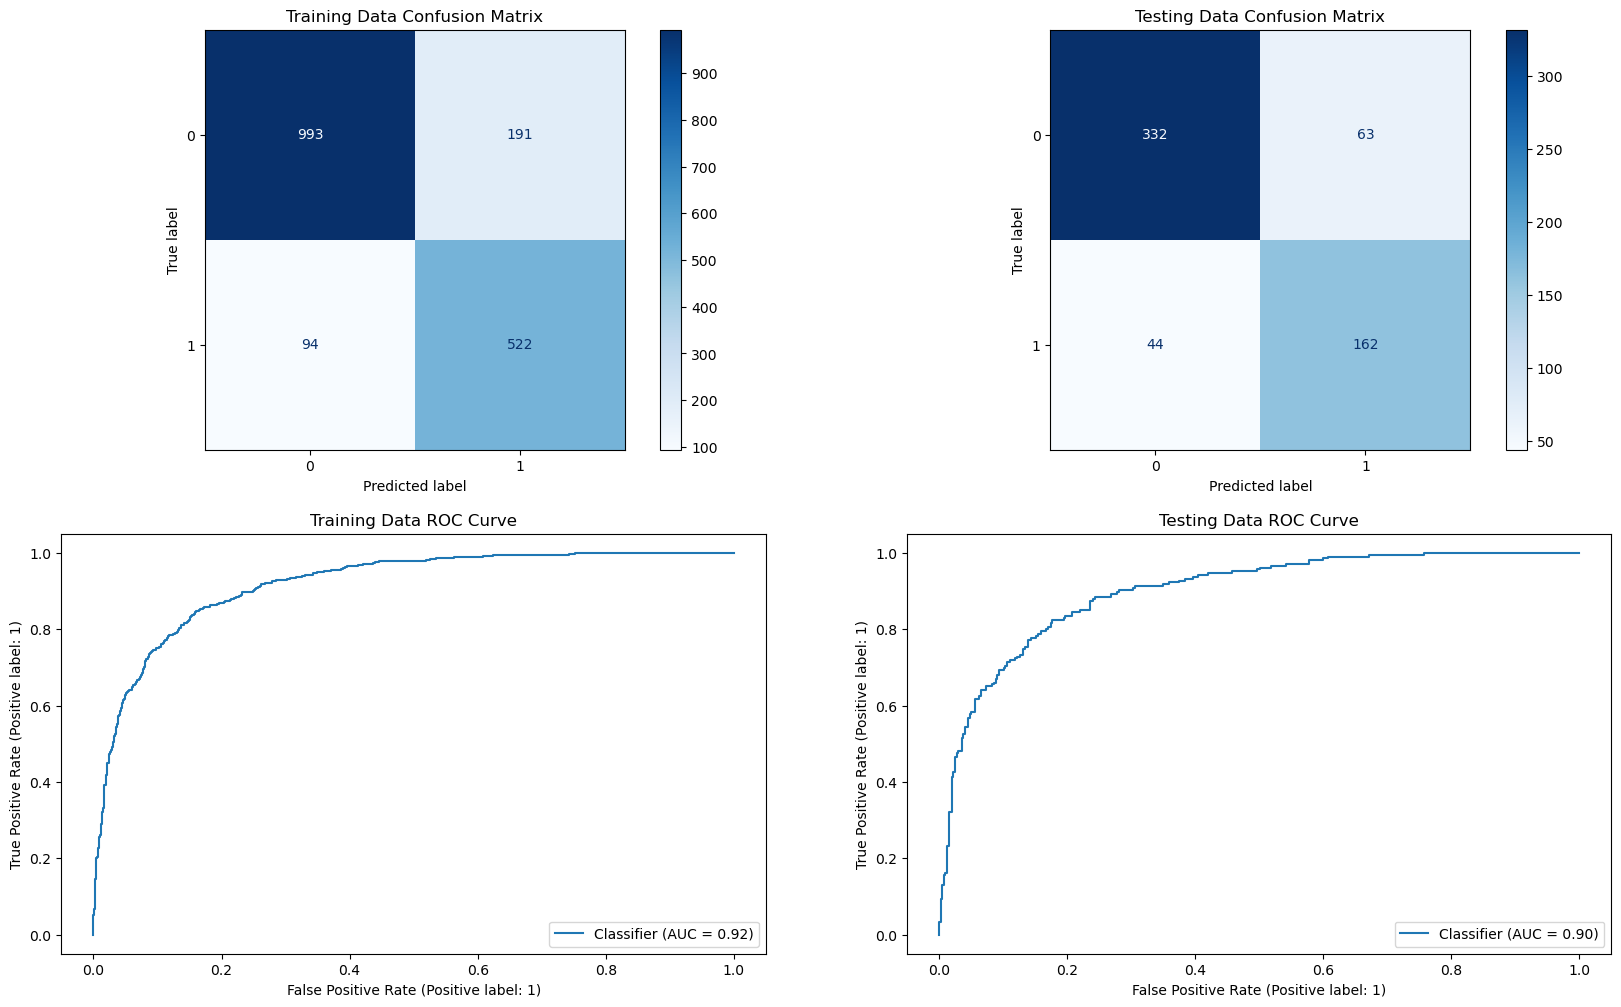

In [74]:
base_log = model_eval(base_log_pipe, X_train, y_train, X_test, y_test, name = 'Base Log')
base_log

A recall of 78.6 on the test data but an AUC of .9. Lets tune the model with Gridsearch and see if we can improve on the score

In [75]:
base_log_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('pipeline-1',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x0000011E8AF6BDC0>),
                                   ('pipeline-2',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(fill_value='Unknown',
                                                                   strategy='constant')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                           

In [76]:
paramslog = {'logisticregression__C': [0.001,0.01,0.1,1,10,100,1000],
         'logisticregression__penalty': ['l1','l2']}

base_log_grid = GridSearchCV(base_log_pipe, paramslog, n_jobs = -1)

base_log_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000011E8AF6BDC0>),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(fill_valu...
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000011E8AF6BC40>)])),
                                       ('smote', SMOTE(random_state=42)),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100,
                                                   1000],
                         'logisticregression__penalty': ['l1', 'l2']})

In [77]:
base_log_grid.best_params_

{'logisticregression__C': 0.1, 'logisticregression__penalty': 'l1'}

In [78]:
tuned_log = base_log_grid.best_estimator_
tuned_log.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000011E8CD27FD0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000011E8CD27160>)])),
                ('smote', SMOTE(random_state=42)),
                ('logisticregression',
                 LogisticRegression(C=0.1, max_iter=1000, penalty='l1',
                                    solver='liblinear'))])

--------TRAINING SET METRICS--------
              precision    recall  f1-score   support

           0       0.91      0.83      0.87      1184
           1       0.72      0.84      0.78       616

    accuracy                           0.84      1800
   macro avg       0.82      0.84      0.82      1800
weighted avg       0.85      0.84      0.84      1800

--------TESTING SET METRICS--------
              precision    recall  f1-score   support

           0       0.88      0.85      0.86       395
           1       0.73      0.78      0.75       206

    accuracy                           0.82       601
   macro avg       0.80      0.81      0.81       601
weighted avg       0.83      0.82      0.83       601



,Train Accuracy,Train Recall,Train Precision,Train F1,Test Accuracy,Test Recall,Test Precision,Test F1
Base Log,0.841667,0.847403,0.732118,0.785553,0.821963,0.786408,0.720000,0.751740
Tuned Log,0.836667,0.842532,0.724860,0.779279,0.823627,0.781553,0.725225,0.752336


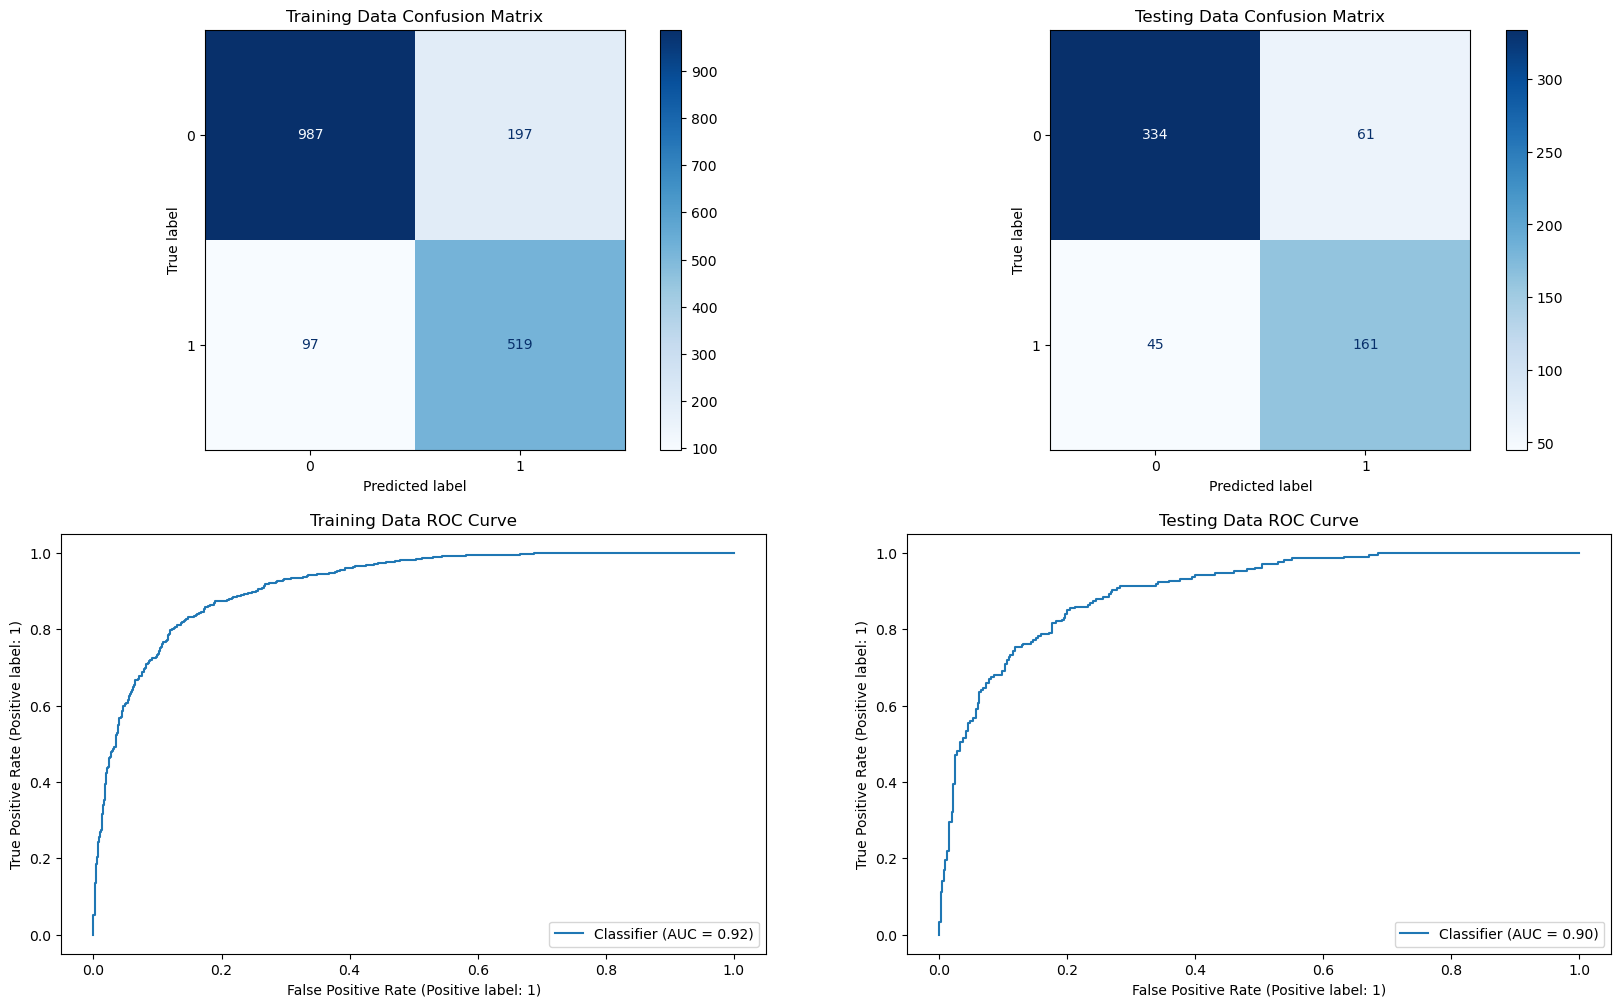

In [79]:
tuned_log_score = model_eval(tuned_log, X_train, y_train, X_test, y_test, 
                             name = 'Tuned Log')
scores = pd.concat([base_log, tuned_log_score])
scores

The tune didn't do too much for us. It reduced the accuracy on the training data but it increased accuracy on testing data. Recall didn't move much though. Lets move on to RandomForest

### RandomForest

In [80]:
randf = RandomForestClassifier(random_state = 42)
rf_pipe = make_pipeline(preprocessor, smote, randf)
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000011E8AF6BDC0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000011E8AF6BC40>)])),
                ('smote', SMOTE(random_state=42)),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

--------TRAINING SET METRICS--------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1184
           1       1.00      1.00      1.00       616

    accuracy                           1.00      1800
   macro avg       1.00      1.00      1.00      1800
weighted avg       1.00      1.00      1.00      1800

--------TESTING SET METRICS--------
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       395
           1       0.82      0.84      0.83       206

    accuracy                           0.88       601
   macro avg       0.87      0.87      0.87       601
weighted avg       0.88      0.88      0.88       601



,Train Accuracy,Train Recall,Train Precision,Train F1,Test Accuracy,Test Recall,Test Precision,Test F1
Base Log,0.841667,0.847403,0.732118,0.785553,0.821963,0.786408,0.720000,0.751740
Tuned Log,0.836667,0.842532,0.724860,0.779279,0.823627,0.781553,0.725225,0.752336
Random Forest Base,1.000000,1.000000,1.000000,1.000000,0.880200,0.839806,0.816038,0.827751


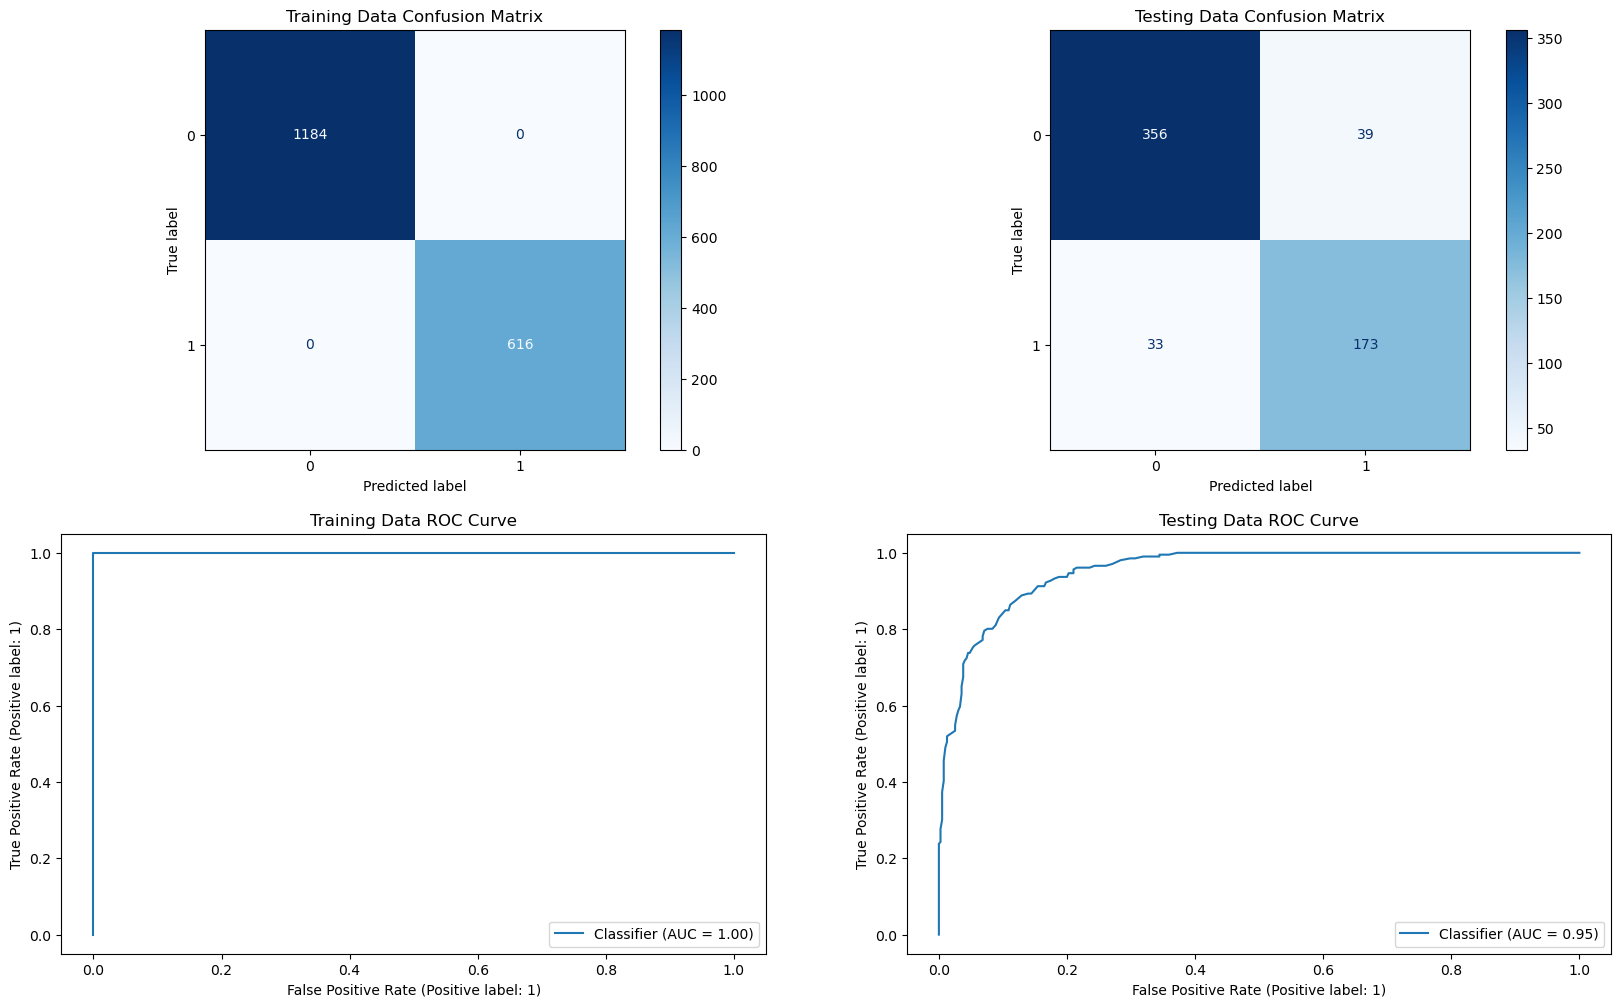

In [81]:
base_rf = model_eval(rf_pipe, X_train, y_train, X_test, y_test, name = 'Random Forest Base')
scores = pd.concat([scores,base_rf])
scores

The model is overfit, as is common for tree models. But the score for accuracy, AUC, and recall are already better than the logistic regression. Lets tune the model using Gridsearch

In [82]:
depth = [i.get_depth() for i in rf_pipe['randomforestclassifier'].estimators_]
max(depth)

21

The code above retrieves the depths for all estimators in the Random Forest model. It then takes the deepest tree. I will use this as my max range for tuning.

In [83]:
rf_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('pipeline-1',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x0000011E8AF6BDC0>),
                                   ('pipeline-2',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(fill_value='Unknown',
                                                                   strategy='constant')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                           

In [84]:
paramsrf = {'randomforestclassifier__max_depth': np.arange(1,10,1),
           'randomforestclassifier__n_estimators': np.arange(100,501,25),
           'randomforestclassifier__min_samples_leaf': [1,5,10],
           'randomforestclassifier__min_samples_split': [2,5,10]}
rf_grid = GridSearchCV(rf_pipe, paramsrf, n_jobs = -1)

In [85]:
%%time
rf_grid.fit(X_train, y_train)

CPU times: total: 18.8 s
Wall time: 3min 50s


GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000011E8AF6BDC0>),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(fill_valu...
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'randomforestclassifier__min_samples_leaf': [1, 5, 10],
                         'randomforestclassifier__min_samples_split': [2, 5,
                                                                       10],
                         'randomforestclassifier__n_estimators': array([100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400,
       425, 450, 475, 500])})

In [86]:
rf_grid.best_params_

{'randomforestclassifier__max_depth': 9,
 'randomforestclassifier__min_samples_leaf': 5,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__n_estimators': 425}

In [87]:
tuned_rf = rf_grid.best_estimator_
tuned_rf.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000011E8D688790>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000011E8D6887F0>)])),
                ('smote', SMOTE(random_state=42)),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=9, min_samples_leaf=5,
                                        n_estimators=425, random_state=42))])

--------TRAINING SET METRICS--------
              precision    recall  f1-score   support

           0       0.97      0.94      0.95      1184
           1       0.89      0.95      0.92       616

    accuracy                           0.94      1800
   macro avg       0.93      0.94      0.94      1800
weighted avg       0.94      0.94      0.94      1800

--------TESTING SET METRICS--------
              precision    recall  f1-score   support

           0       0.93      0.90      0.91       395
           1       0.82      0.87      0.85       206

    accuracy                           0.89       601
   macro avg       0.87      0.89      0.88       601
weighted avg       0.89      0.89      0.89       601



,Train Accuracy,Train Recall,Train Precision,Train F1,Test Accuracy,Test Recall,Test Precision,Test F1
Base Log,0.841667,0.847403,0.732118,0.785553,0.821963,0.786408,0.720000,0.751740
Tuned Log,0.836667,0.842532,0.724860,0.779279,0.823627,0.781553,0.725225,0.752336
Random Forest Base,1.000000,1.000000,1.000000,1.000000,0.880200,0.839806,0.816038,0.827751
Tuned Random Forest,0.941667,0.952922,0.885370,0.917905,0.890183,0.873786,0.818182,0.845070


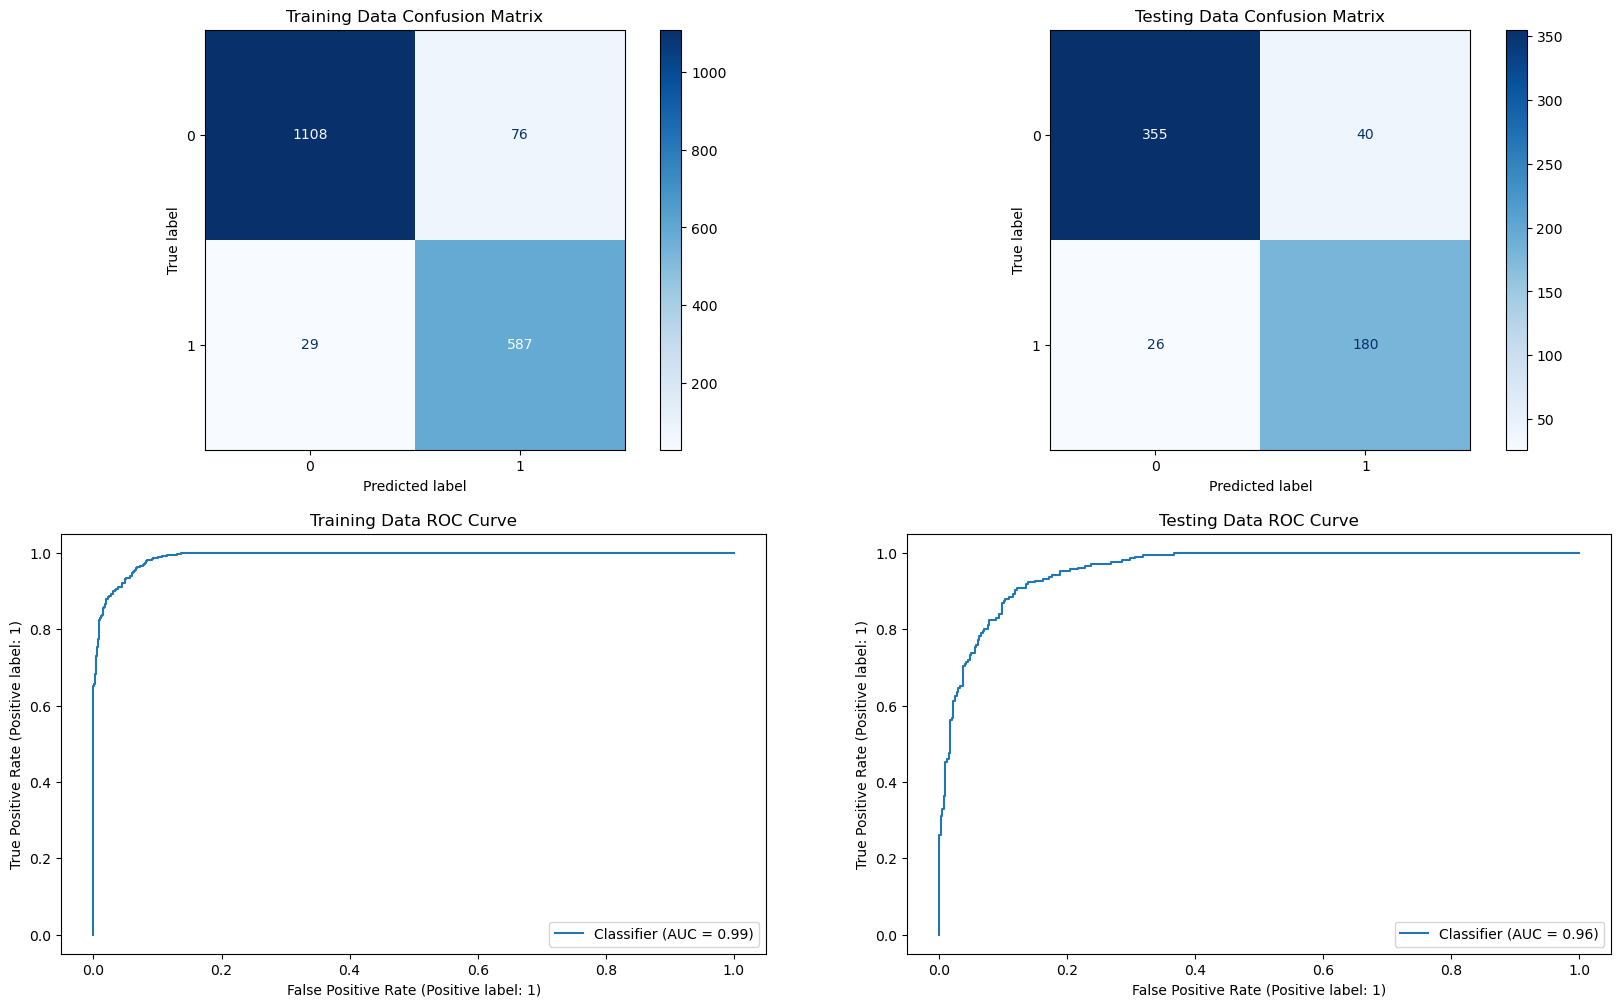

In [88]:
tuned_rf_score = model_eval(tuned_rf, X_train, y_train, X_test, y_test, 
                            name = 'Tuned Random Forest')
scores = pd.concat([scores, tuned_rf_score])
scores

The tuned Random Forest model got an increase to Accuracy and Recall. It is the best model yet. Lets try a boosted model next

### LightGBM

In [89]:
lgbm = LGBMClassifier(random_state = 42)
lgbm_pipe = make_pipeline(preprocessor, smote, lgbm)

lgbm_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000011E8AF6BDC0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000011E8AF6BC40>)])),
                ('smote', SMOTE(random_state=42)),
                ('lgbmclassifier', LGBMClassifier(random_state=42))])

--------TRAINING SET METRICS--------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1184
           1       1.00      1.00      1.00       616

    accuracy                           1.00      1800
   macro avg       1.00      1.00      1.00      1800
weighted avg       1.00      1.00      1.00      1800

--------TESTING SET METRICS--------
              precision    recall  f1-score   support

           0       0.91      0.92      0.91       395
           1       0.84      0.82      0.83       206

    accuracy                           0.89       601
   macro avg       0.87      0.87      0.87       601
weighted avg       0.88      0.89      0.88       601



,Train Accuracy,Train Recall,Train Precision,Train F1,Test Accuracy,Test Recall,Test Precision,Test F1
Base Log,0.841667,0.847403,0.732118,0.785553,0.821963,0.786408,0.720000,0.751740
Tuned Log,0.836667,0.842532,0.724860,0.779279,0.823627,0.781553,0.725225,0.752336
Random Forest Base,1.000000,1.000000,1.000000,1.000000,0.880200,0.839806,0.816038,0.827751
Tuned Random Forest,0.941667,0.952922,0.885370,0.917905,0.890183,0.873786,0.818182,0.845070
LightGBM Base,1.000000,1.000000,1.000000,1.000000,0.885191,0.815534,0.844221,0.829630


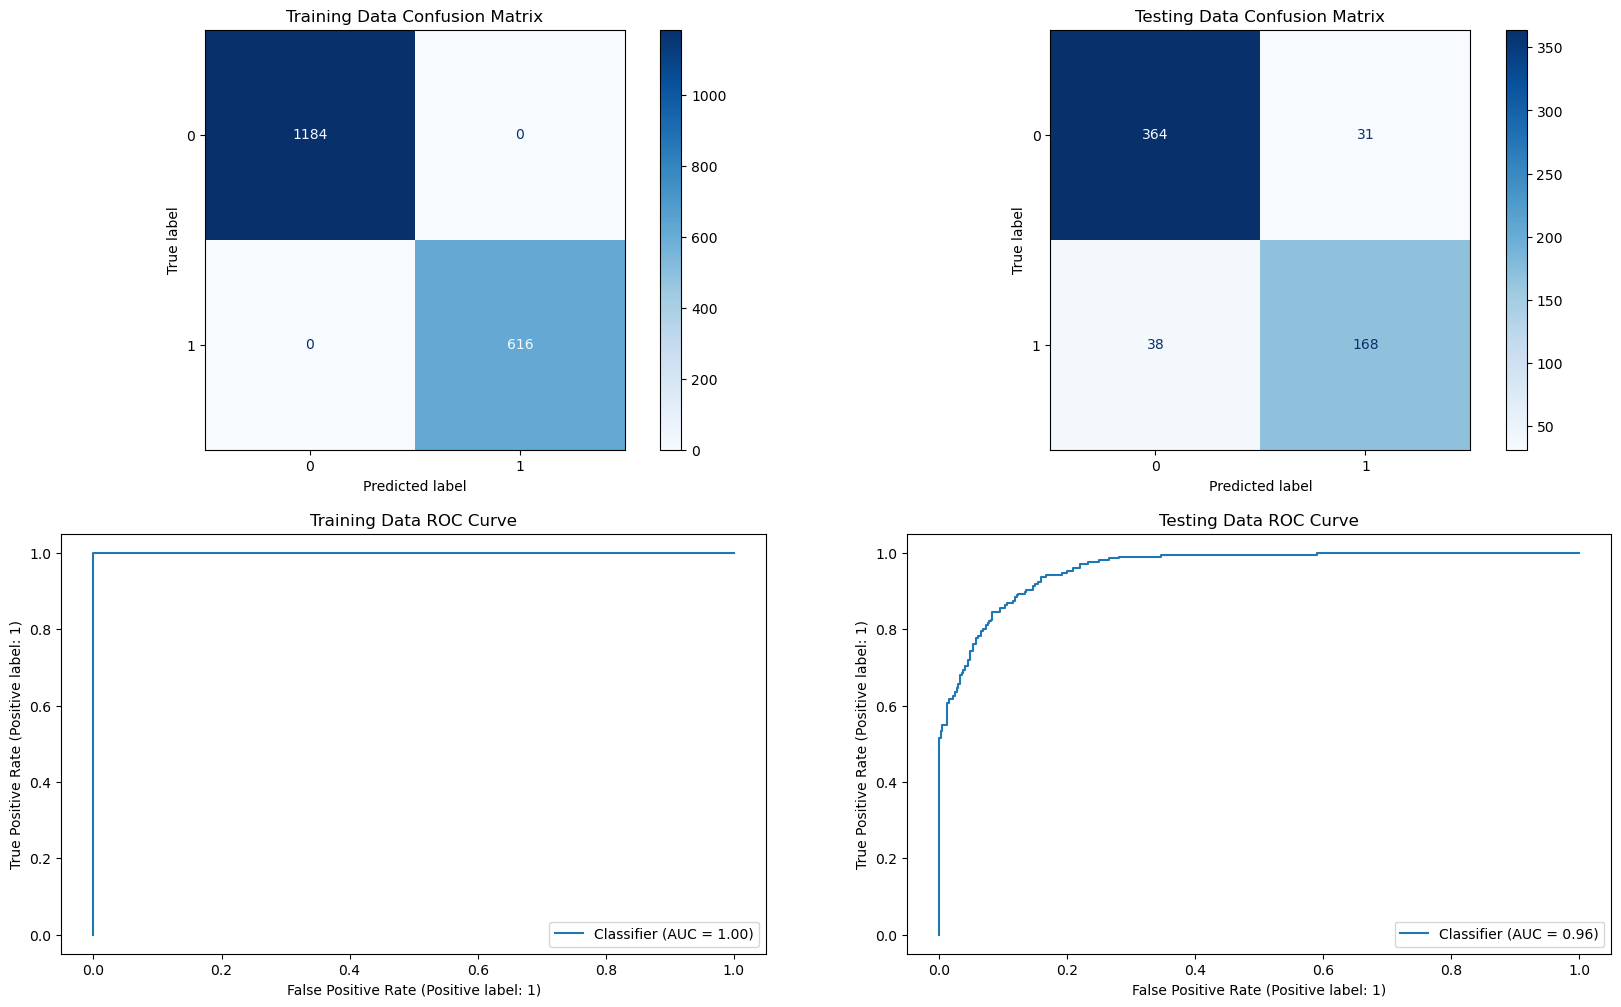

In [90]:
base_lgbm = model_eval(lgbm_pipe, X_train, y_train, X_test, y_test, 
                       name = 'LightGBM Base')
scores = pd.concat([scores, base_lgbm])
scores

LightGBM did not do as well as the Random Forest. Lets tweak it a bit and see if we can outperform it

In [91]:
lgbm_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('pipeline-1',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x0000011E8AF6BDC0>),
                                   ('pipeline-2',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(fill_value='Unknown',
                                                                   strategy='constant')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                           

In [92]:
paramslgbm = {'lgbmclassifier__reg_alpha': np.arange(0,101,10),
         'lgbmclassifier__reg_lambda': np.arange(0,101,10),
         'lgbmclassifier__n_estimators': np.arange(100,301,10),
         'lgbmclassifier__max_depth': np.arange(1,6,1)}
lgbm_grid = GridSearchCV(lgbm_pipe, paramslgbm, n_jobs = -1)

In [93]:
%%time
lgbm_grid.fit(X_train, y_train)

CPU times: total: 2min 38s
Wall time: 13min 48s


GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000011E8AF6BDC0>),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(fill_valu...
                                        LGBMClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'lgbmclassifier__max_depth': array([1, 2, 3, 4, 5]),
                         'lgbmclassifier__n_estimators': array([100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220,
       230, 240, 250, 260, 270, 280, 290, 300]),
                         'lgbmclassifier__reg_alpha': array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100]),
                         'lgbmclassifier__reg_lambda': array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100])})

In [94]:
lgbm_grid.best_params_

{'lgbmclassifier__max_depth': 4,
 'lgbmclassifier__n_estimators': 200,
 'lgbmclassifier__reg_alpha': 0,
 'lgbmclassifier__reg_lambda': 20}

In [95]:
tuned_lgbm = lgbm_grid.best_estimator_
tuned_lgbm.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000011E8DF23460>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000011E8CD11910>)])),
                ('smote', SMOTE(random_state=42)),
                ('lgbmclassifier',
                 LGBMClassifier(max_depth=4, n_estimators=200, random_state=42,
                                reg_alpha=0, reg_lambda=20))])

--------TRAINING SET METRICS--------
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1184
           1       0.93      0.97      0.95       616

    accuracy                           0.97      1800
   macro avg       0.96      0.97      0.96      1800
weighted avg       0.97      0.97      0.97      1800

--------TESTING SET METRICS--------
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       395
           1       0.81      0.88      0.84       206

    accuracy                           0.89       601
   macro avg       0.87      0.89      0.88       601
weighted avg       0.89      0.89      0.89       601



,Train Accuracy,Train Recall,Train Precision,Train F1,Test Accuracy,Test Recall,Test Precision,Test F1
Base Log,0.841667,0.847403,0.732118,0.785553,0.821963,0.786408,0.720000,0.751740
Tuned Log,0.836667,0.842532,0.724860,0.779279,0.823627,0.781553,0.725225,0.752336
Random Forest Base,1.000000,1.000000,1.000000,1.000000,0.880200,0.839806,0.816038,0.827751
Tuned Random Forest,0.941667,0.952922,0.885370,0.917905,0.890183,0.873786,0.818182,0.845070
LightGBM Base,1.000000,1.000000,1.000000,1.000000,0.885191,0.815534,0.844221,0.829630
Tuned LGBM,0.966111,0.974026,0.930233,0.951626,0.888519,0.878641,0.811659,0.843823


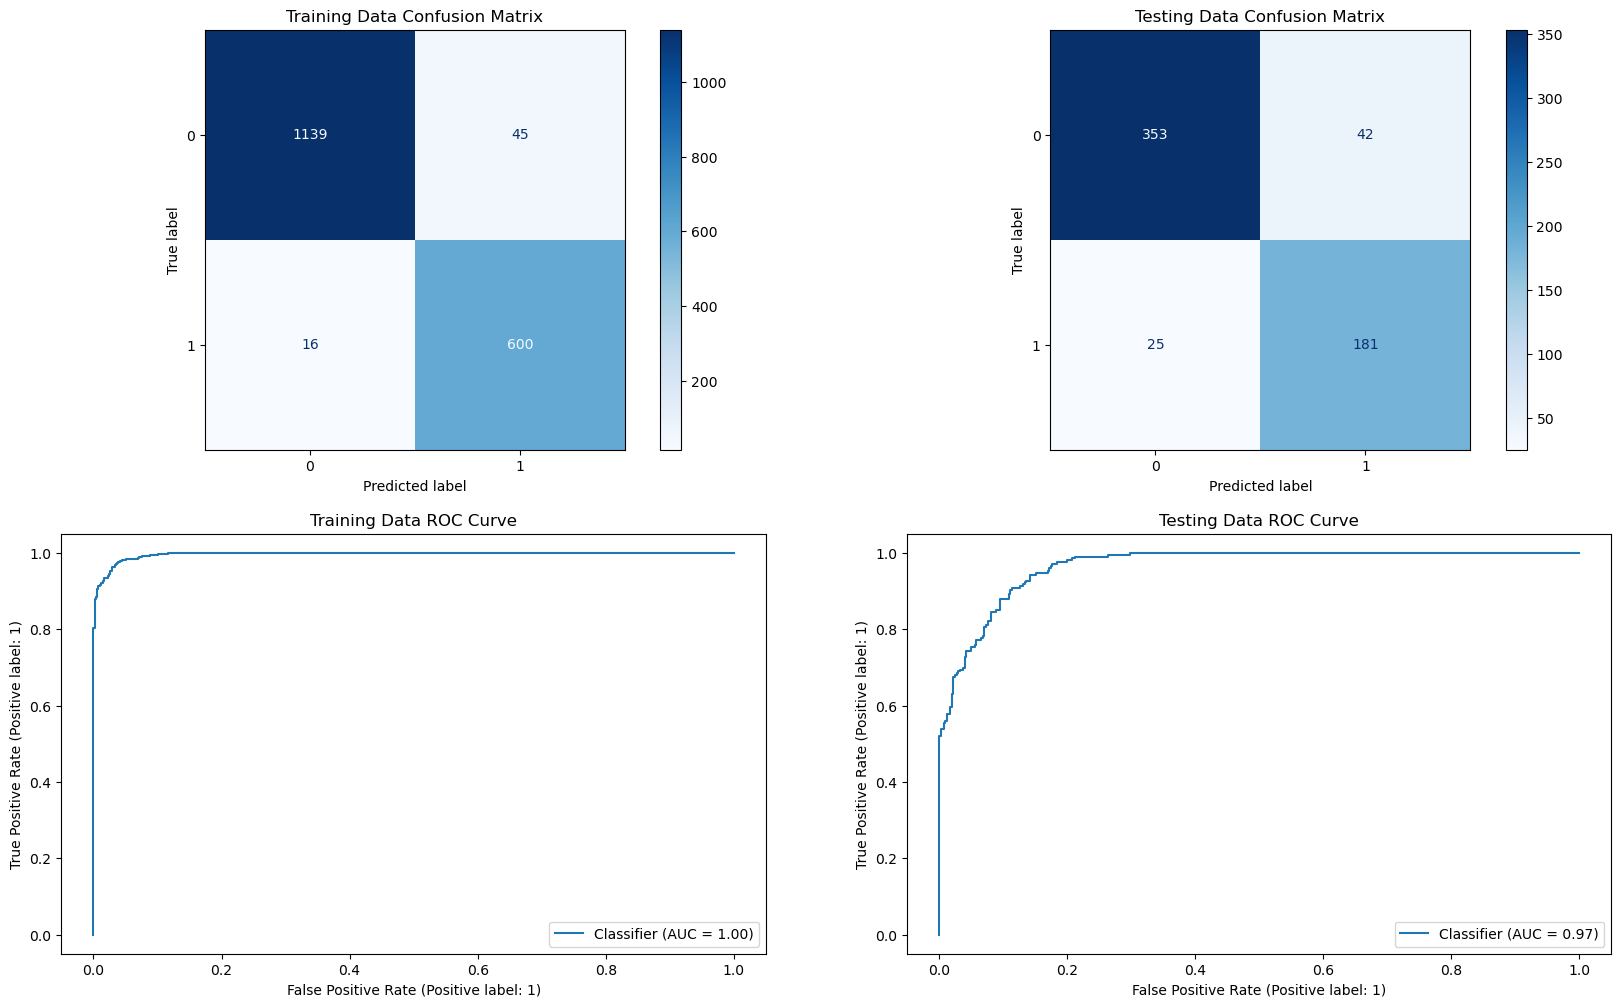

In [96]:
tuned_lgbm_score = model_eval(tuned_lgbm, X_train, y_train, X_test, y_test, 
                              name = 'Tuned LGBM')
scores = pd.concat([scores, tuned_lgbm_score])
scores

The tuned LightGBM gave us the best results. It had an increase in accuracy and recall. The tuning stopped overfitting and produced the best results on the testing data. Given that we want to maximize recall, LightGBM was the best model. 

## Feature Engineering
I am going to create some ordinal columns and remove what I think are extra columns from the data. I will then run a PCA on the data and fit the model to those PCs to see if it improves model speed or accuracy

In [97]:
dfml2 = data.copy()

In [98]:
dfml2['MetabolicSyndrome'].replace({'No MetSyn':0,'MetSyn':1}, inplace = True)
dfml2.drop(columns = ['seqn'], inplace = True)
dfml2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2401 entries, 0 to 2400
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                2401 non-null   int64  
 1   Sex                2401 non-null   object 
 2   Marital            2193 non-null   object 
 3   Income             2284 non-null   float64
 4   Race               2401 non-null   object 
 5   WaistCirc          2316 non-null   float64
 6   BMI                2375 non-null   float64
 7   Albuminuria        2401 non-null   int64  
 8   UrAlbCr            2401 non-null   float64
 9   UricAcid           2401 non-null   float64
 10  BloodGlucose       2401 non-null   int64  
 11  HDL                2401 non-null   int64  
 12  Triglycerides      2401 non-null   int64  
 13  MetabolicSyndrome  2401 non-null   int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 262.7+ KB


### New Features

In [99]:
# Triglycerides
"""I want to group Triglycerides into an ordinal column and see how it impacts model 
performance"""
dfml2.loc[(dfml2['Triglycerides']<150),'TriglyceridesCat'] = 0
dfml2.loc[(dfml2['Triglycerides']>=150) & (dfml2['Triglycerides']<200),'TriglyceridesCat'] = 1
dfml2.loc[(dfml2['Triglycerides']>=200) & (dfml2['Triglycerides']<500),'TriglyceridesCat'] = 2
dfml2.loc[(dfml2['Triglycerides']>=500),'TriglyceridesCat'] = 3

# Blood Glucose
"""I am going to make a High BloodGlucose column that checks if fasted BloodGlucose is 
above or below 100"""
dfml2['HighBloodGlucose'] = 0
dfml2.loc[(dfml2['BloodGlucose']>99), 'HighBloodGlucose'] = 1

# BMI 
"""BMI could be controversial, as it differs for people of different age, sex, and race. 
I want to see if there is any value in grouping BMI by the standards provided by some 
studies. Specifically, I want to group the low to moderate risk range together, and the
high ranges together."""
dfml2['BMIRisk'] = 1
dfml2.loc[(dfml2['BMI']>=18.5) & (dfml2['BMI']<30),'BMIRisk'] = 0

# TG/HDL Ratio
"""The Triglycerides to HDL ratio is an important ratio for predicting heart disease and
insulin resistance. Lets use it here and see if it improves model performance"""
dfml2['TGtoHDL'] = dfml2['Triglycerides']/dfml2['HDL']

# Sex
"""Converting Sex to IsMale"""
dfml2['Sex'].replace({'Male':1,'Female':0}, inplace = True)
dfml2.rename(columns = {'Sex':'IsMale'}, inplace = True)

dfml2.head()

,Age,IsMale,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome,TriglyceridesCat,HighBloodGlucose,BMIRisk,TGtoHDL
0,22,1,Single,8200.0,White,81.0,23.3,0,3.88,4.9,92,41,84,0,0.0,0,0,2.048780
1,44,0,Married,4500.0,White,80.1,23.2,0,8.55,4.5,82,28,56,0,0.0,0,0,2.000000
2,21,1,Single,800.0,Asian,69.6,20.1,0,5.07,5.4,107,43,78,0,0.0,1,0,1.813953
3,43,0,Single,2000.0,Black,120.4,33.3,0,5.22,5.0,104,73,141,0,0.0,1,1,1.931507
4,51,1,Married,NaN,Asian,81.1,20.1,0,8.13,5.0,95,43,126,0,0.0,0,0,2.930233


In [100]:
# Dropping the columns that were feature engineered
dfml2.drop(columns = ['Triglycerides','UrAlbCr', 'BloodGlucose', 'BMI', 'HDL'], inplace = True)
dfml2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2401 entries, 0 to 2400
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                2401 non-null   int64  
 1   IsMale             2401 non-null   int64  
 2   Marital            2193 non-null   object 
 3   Income             2284 non-null   float64
 4   Race               2401 non-null   object 
 5   WaistCirc          2316 non-null   float64
 6   Albuminuria        2401 non-null   int64  
 7   UricAcid           2401 non-null   float64
 8   MetabolicSyndrome  2401 non-null   int64  
 9   TriglyceridesCat   2401 non-null   float64
 10  HighBloodGlucose   2401 non-null   int64  
 11  BMIRisk            2401 non-null   int64  
 12  TGtoHDL            2401 non-null   float64
dtypes: float64(5), int64(6), object(2)
memory usage: 244.0+ KB


In [101]:
# New instance of X and y
X = dfml2.drop(columns = ['MetabolicSyndrome'])
y = dfml2['MetabolicSyndrome']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [103]:
# Replacing Outliers again
replace_outliers(X_train, column = ['WaistCirc','UricAcid'])

### Model Fitting
Now lets test this new engineered dataset with the best tuned model from before

In [104]:
# Reinstancing the model
tuned_lgbm2 = lgbm_grid.best_estimator_
tuned_lgbm2.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000011E8DF23460>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000011E8CD11910>)])),
                ('smote', SMOTE(random_state=42)),
                ('lgbmclassifier',
                 LGBMClassifier(max_depth=4, n_estimators=200, random_state=42,
                                reg_alpha=0, reg_lambda=20))])

--------TRAINING SET METRICS--------
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      1182
           1       0.87      0.95      0.91       618

    accuracy                           0.94      1800
   macro avg       0.92      0.94      0.93      1800
weighted avg       0.94      0.94      0.94      1800

--------TESTING SET METRICS--------
              precision    recall  f1-score   support

           0       0.92      0.89      0.90       397
           1       0.80      0.85      0.82       204

    accuracy                           0.88       601
   macro avg       0.86      0.87      0.86       601
weighted avg       0.88      0.88      0.88       601



,Train Accuracy,Train Recall,Train Precision,Train F1,Test Accuracy,Test Recall,Test Precision,Test F1
Base Log,0.841667,0.847403,0.732118,0.785553,0.821963,0.786408,0.720000,0.751740
Tuned Log,0.836667,0.842532,0.724860,0.779279,0.823627,0.781553,0.725225,0.752336
Random Forest Base,1.000000,1.000000,1.000000,1.000000,0.880200,0.839806,0.816038,0.827751
Tuned Random Forest,0.941667,0.952922,0.885370,0.917905,0.890183,0.873786,0.818182,0.845070
LightGBM Base,1.000000,1.000000,1.000000,1.000000,0.885191,0.815534,0.844221,0.829630
Tuned LGBM,0.966111,0.974026,0.930233,0.951626,0.888519,0.878641,0.811659,0.843823
Tuned LGBM2,0.935000,0.951456,0.871111,0.909513,0.875208,0.848039,0.797235,0.821853


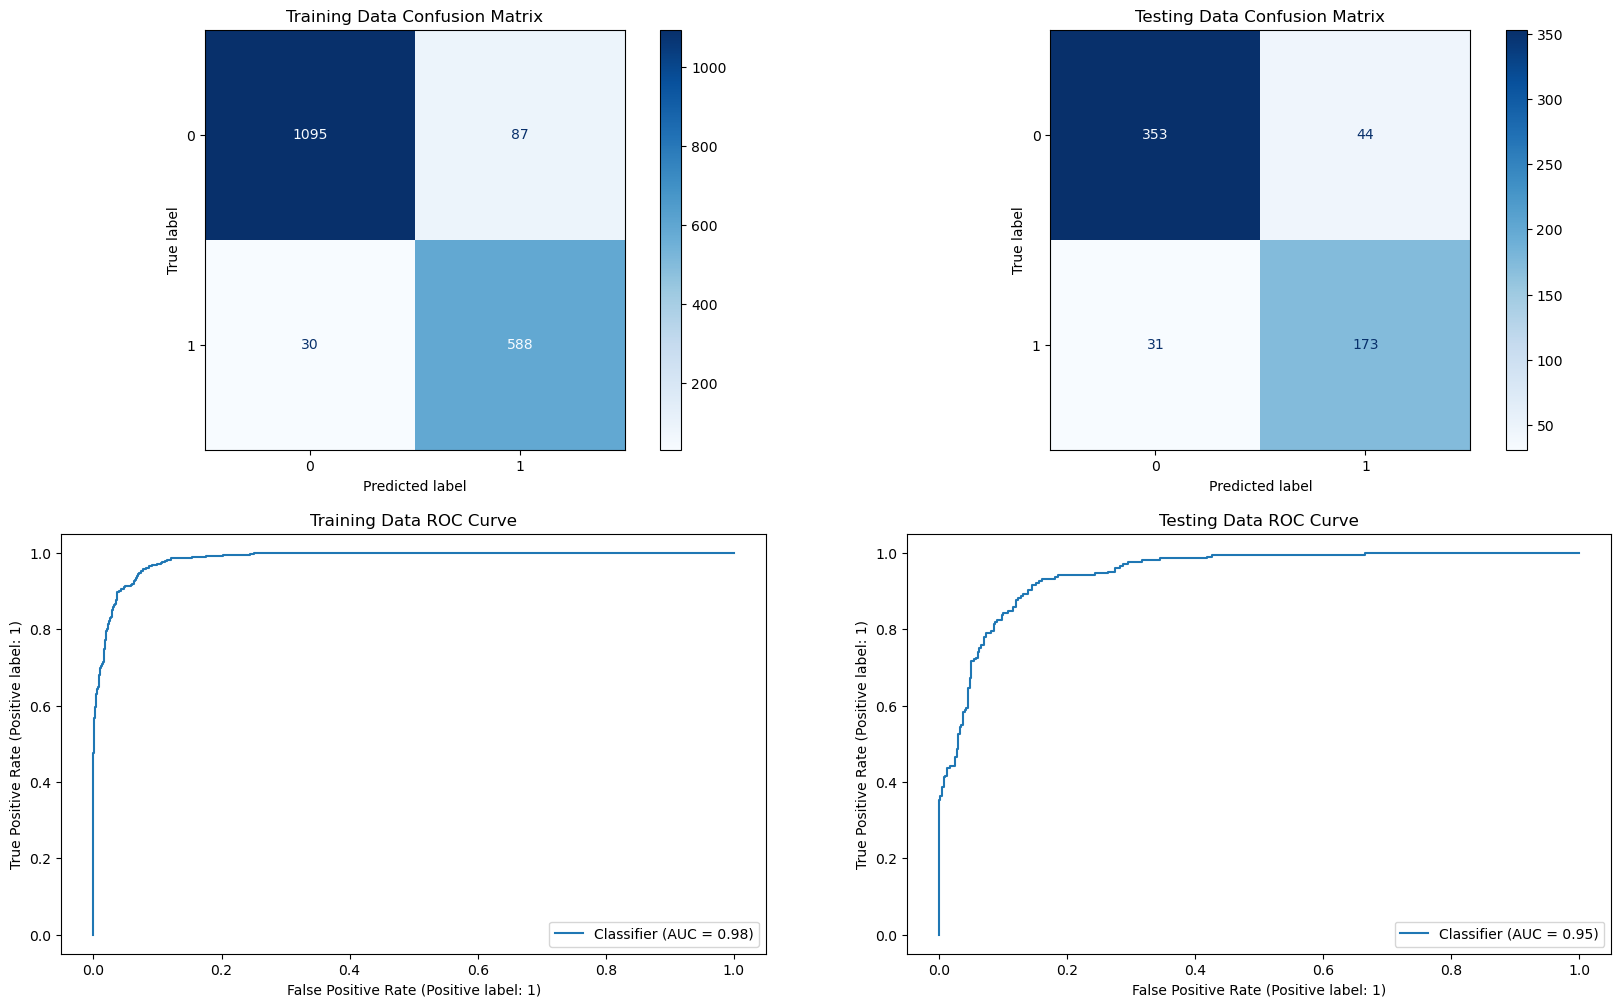

In [105]:
tuned_lgbm_score2 = model_eval(tuned_lgbm2, X_train, y_train, X_test, y_test, 
                              name = 'Tuned LGBM2')
scores = pd.concat([scores, tuned_lgbm_score2])
scores

Feature engineering produced an overall worse result using the best fit model from before. 

### PCA
Lets take a look at using PCA. I need to run PCA on the whole feature dataset so i can pick my n_components

In [106]:
pca = PCA()
processedX = preprocessor.fit_transform(X)
pca.fit(processedX)

PCA()

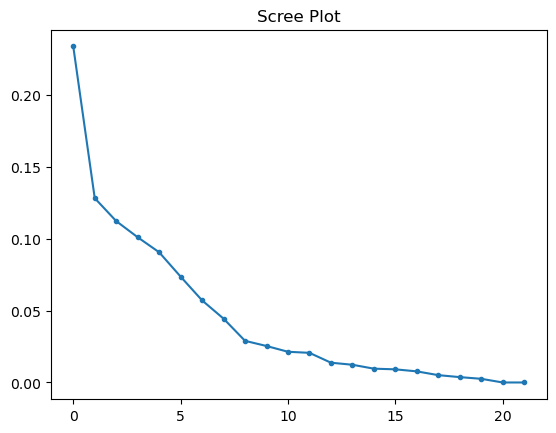

In [107]:
plt.plot(pca.explained_variance_ratio_, marker = '.')
plt.title('Scree Plot');

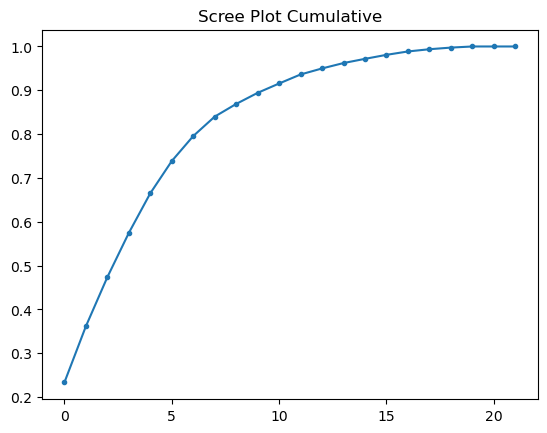

In [108]:
plt.plot(pca.explained_variance_ratio_.cumsum(), marker = '.')
plt.title('Scree Plot Cumulative');

Based on these graphs, I think I can get a good tradeoff around 90%, which is close to 10 components. 

## Final LGBM
Lets combine the Feature Engineering and PCA into one model and see if it produces better results

In [109]:
pca90 = PCA(n_components = 10)

In [110]:
lgbm_best_model = LGBMClassifier(max_depth = 4, n_estimators = 200, reg_alpha = 0, 
                                 reg_lambda = 20)
lgbm_pca_pipe = make_pipeline(preprocessor, smote, pca90,lgbm_best_model)

In [111]:
lgbm_pca_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000011E8AF6BDC0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000011E8AF6BC40>)])),
                ('smote', SMOTE(random_state=42)),
                ('pca', PCA(n_components=10)),
                ('lgbmclassifier',
                 LGBMClassifier(max_depth=4, n_estimators=200, reg_alpha=0,
                                reg_lambda=20))])

--------TRAINING SET METRICS--------
              precision    recall  f1-score   support

           0       0.98      0.93      0.95      1182
           1       0.87      0.96      0.91       618

    accuracy                           0.94      1800
   macro avg       0.92      0.94      0.93      1800
weighted avg       0.94      0.94      0.94      1800

--------TESTING SET METRICS--------
              precision    recall  f1-score   support

           0       0.91      0.86      0.89       397
           1       0.75      0.84      0.80       204

    accuracy                           0.85       601
   macro avg       0.83      0.85      0.84       601
weighted avg       0.86      0.85      0.86       601



,Train Accuracy,Train Recall,Train Precision,Train F1,Test Accuracy,Test Recall,Test Precision,Test F1
Base Log,0.841667,0.847403,0.732118,0.785553,0.821963,0.786408,0.720000,0.751740
Tuned Log,0.836667,0.842532,0.724860,0.779279,0.823627,0.781553,0.725225,0.752336
Random Forest Base,1.000000,1.000000,1.000000,1.000000,0.880200,0.839806,0.816038,0.827751
Tuned Random Forest,0.941667,0.952922,0.885370,0.917905,0.890183,0.873786,0.818182,0.845070
LightGBM Base,1.000000,1.000000,1.000000,1.000000,0.885191,0.815534,0.844221,0.829630
Tuned LGBM,0.966111,0.974026,0.930233,0.951626,0.888519,0.878641,0.811659,0.843823
Tuned LGBM2,0.935000,0.951456,0.871111,0.909513,0.875208,0.848039,0.797235,0.821853
LGBM with PCA,0.937778,0.957929,0.873156,0.913580,0.853577,0.843137,0.754386,0.796296


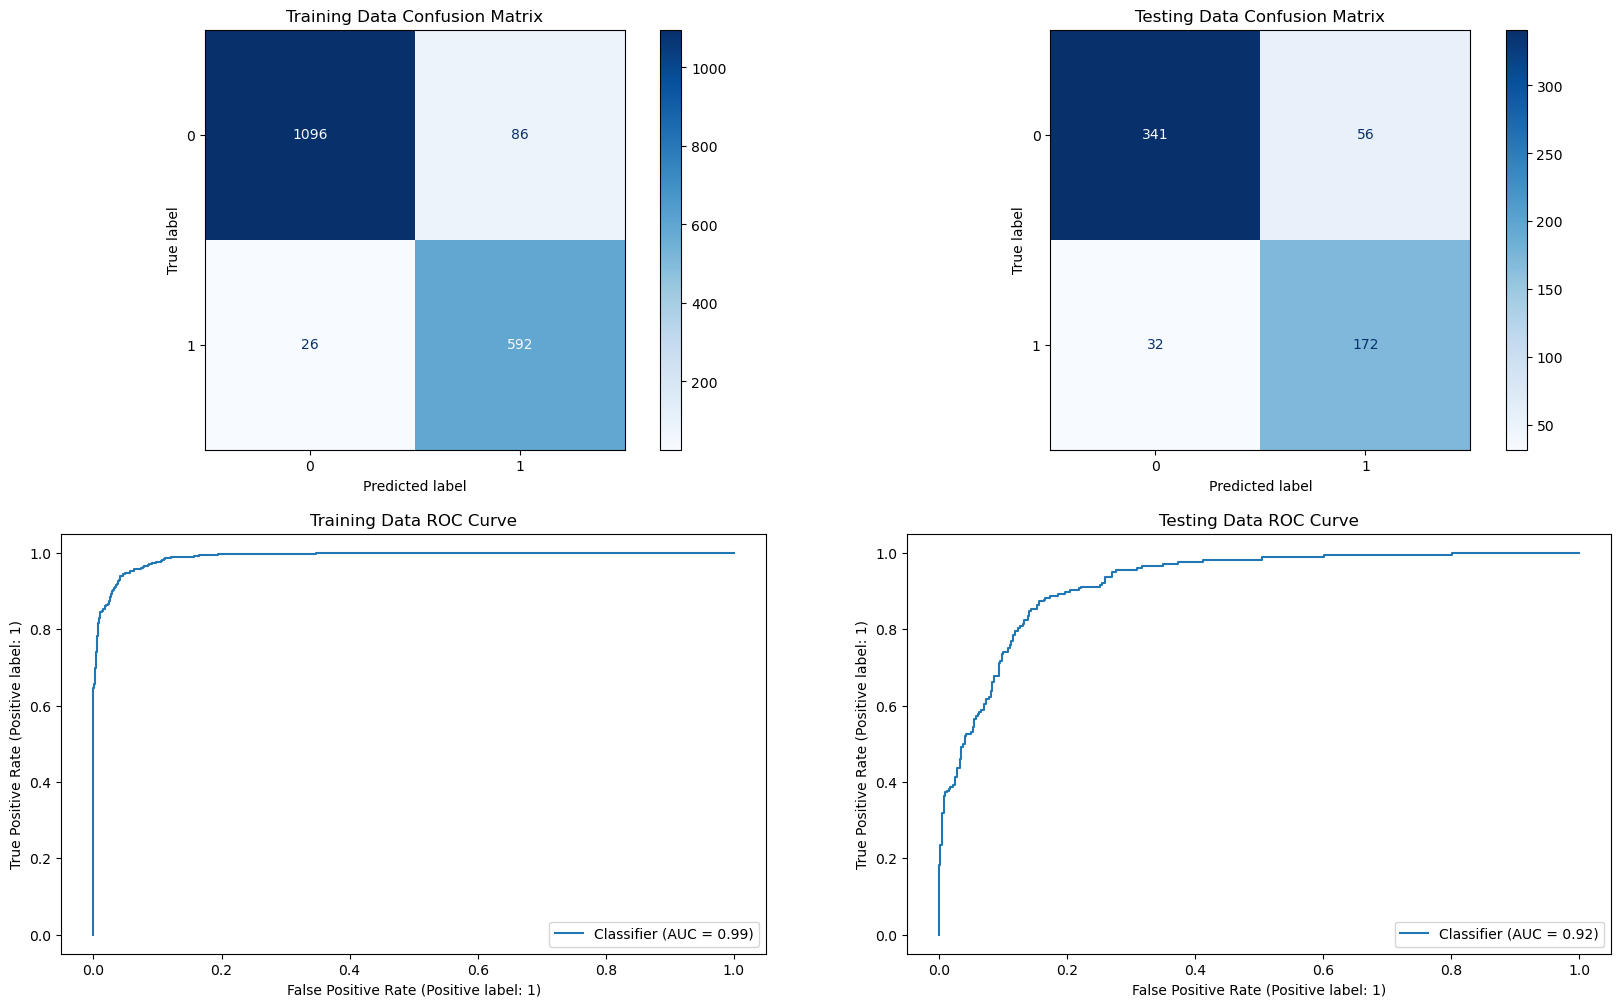

In [112]:
LGBM_with_pca = model_eval(lgbm_pca_pipe, X_train, y_train, X_test, y_test, 
                           name = 'LGBM with PCA')
scores = pd.concat([scores,LGBM_with_pca])
scores

Adding the engineered features and using PCA made the model worse and is not worth implementing in production. The best model was:

Tuned Light Gradient Boost Classifier:
* Max Depth: 4
* Number of Estimators: 200
* Lambda Regularization: 20